In [1]:
library(dplyr)
library(stringr)
library(Seurat) 
library(ggplot2)
library(RColorBrewer)
library(viridis)
library(ggrepel)
library(reshape2)
library(stringdist)
library(ggbeeswarm)
library(ggpubr)
library(shazam)
library(alakazam)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.1 but the current version is
4.3.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: viridisLite

Warning message:
“package ‘stringdist’ was built under R version 4.3.3”


To cite the SHazaM package in publications, please use:

  Gupta N, Vander Heiden J, Uduman M, Gadala-Maria D, Yaari G,
  Kleinstein S (2015). “Change-O: a toolkit for ana

In [2]:
group.col=c('Alum-pSer'='#0072B2','SMNP'='#E69F00','Alum-pSer/SMNP'='#009E73')
my.comparison = list(c('Alum-pSer','SMNP'),c('SMNP','Alum-pSer/SMNP'),c('Alum-pSer','Alum-pSer/SMNP'))
Axis_themes <- theme(plot.title = element_text(size = 8,hjust=0.5),
                     axis.title = element_text(size = 8),
                     axis.text = element_text(size = 8,color='black'),
                     axis.text.x = element_text(size = 8,angle=45,hjust=1),                     
                     legend.text = element_text(size = 8),
                     legend.title = element_text(size = 8),
                     legend.key.size = unit(.3, 'cm'),
                     strip.text.x = element_text(size = 8),
                     strip.background = element_rect(fill=NA,linewidth=.3,color='black'),
                     axis.line = element_line(linewidth = .3),
                     axis.ticks = element_line(linewidth = 0.3))

In [3]:
hc = read.table('bcr_output/05_hc_private_clones_germ-pass.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t') 
dim(hc)
lc = read.table('bcr_output/03_lc_translated.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t') 
dim(lc)

[1] 4637   95

[1] 8715   86

In [4]:
# add SHM
hc = hc %>% 
     observedMutations(sequenceColumn = 'CONSENSUS_SEQUENCE',germlineColumn = 'GERMLINE_SEQUENCE_D_MASK', 
                       frequency = FALSE,combine=TRUE) #%>%
     # observedMutations(sequenceColumn = 'CONSENSUS_SEQUENCE',germlineColumn = 'GERMLINE_SEQUENCE_D_MASK', 
     #                   frequency = TRUE,combine=TRUE)

lc = lc %>% 
     observedMutations(sequenceColumn = 'CONSENSUS_SEQUENCE',germlineColumn = 'GERMLINE_IMGT', 
                       frequency = FALSE,combine=TRUE) #%>% 
     # observedMutations(sequenceColumn = 'CONSENSUS_SEQUENCE',germlineColumn = 'GERMLINE_IMGT', 
     #                   frequency = TRUE,combine=TRUE)

In [5]:
srat = readRDS('seurat_object/01_harmony_labeled.RDS')
srat$group = factor(srat$group, levels=c('Alum-pSer','SMNP','Alum-pSer/SMNP'))
srat

An object of class Seurat 
26779 features across 19537 samples within 2 assays 
Active assay: RNA (26769 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 1 other assay present: HTO
 3 dimensional reductions calculated: pca, harmony, umap

In [6]:
metadata = srat@meta.data

hc.match = hc %>% filter(hc$LANE_ID %in% metadata$cell_id)
dim(hc)
lc.match = lc %>% filter(lc$LANE_ID %in% metadata$cell_id)
dim(lc)
metadata$IGH_recovery = as.numeric(metadata$cell_id %in% hc$LANE_ID) * 2
metadata$IGL_recovery = as.numeric(metadata$cell_id %in% lc$LANE_ID)
metadata$recovery = metadata$IGH_recovery + metadata$IGL_recovery

# add heavy chain info to metadata 
a = hc.match[c('LANE_ID','ISOTYPE','CDR3NUC','CDR3',
               'CLONE','GERMLINE_V_CALL','mu_count')] #,'mu_freq'
colnames(a)<-paste('IGH',colnames(a),sep="_")
metadata = merge(metadata, a,by.x='cell_id', by.y='IGH_LANE_ID', all.x=TRUE)
rownames(metadata)= metadata$cell_id
metadata = metadata %>% dplyr::rename('CLONE'='IGH_CLONE')

# add light chain info to metadata 
b = lc.match[c('LANE_ID','ISOTYPE','CDR3nuc','CDR3','V_CALL','mu_count')]
colnames(b)<-paste('IGL',colnames(b),sep="_")
b = b %>% mutate(IGL_V_CALL = str_split_i(IGL_V_CALL,',',1))
metadata = merge(metadata, b,by.x='cell_id', by.y='IGL_LANE_ID', all.x=TRUE)
rownames(metadata)= metadata$cell_id

srat@meta.data = metadata 

[1] 4637   96

[1] 8715   87

In [7]:
table(srat$recovery, srat$group)

   
    Alum-pSer SMNP Alum-pSer/SMNP
  0      4632 1084           3480
  1      1186 1106           3428
  2       236  269           1166
  3       426  583           1941

In [8]:
table(srat$IGH_recovery)
table(srat$IGL_recovery)
table(srat$recovery)


    0     2 
14916  4621 


    0     1 
10867  8670 


   0    1    2    3 
9196 5720 1671 2950 

In [21]:
metadata = srat@meta.data
metadata %>% 
# filter(IGH_recovery>0) %>% 
#filter(IGL_recovery>0) %>% 
filter(recovery==3) %>% 
group_by(group, mouse.id) %>% 
summarise(ncell=n()) %>% 
filter(ncell>1) %>% summarise(nmouse = n()) # number of mouse


`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


group          nmouse
1 Alum-pSer      19    
2 SMNP           10    
3 Alum-pSer/SMNP 13

In [38]:
# total unique clone
metadata = srat@meta.data
metadata %>% 
filter(IGH_recovery>0) %>% 
# filter(IGL_recovery>0) %>% 
# filter(recovery==3) %>% 
count(group,CLONE) %>% count(group) # number of clones

group          n  
1 Alum-pSer      470
2 SMNP           337
3 Alum-pSer/SMNP 953

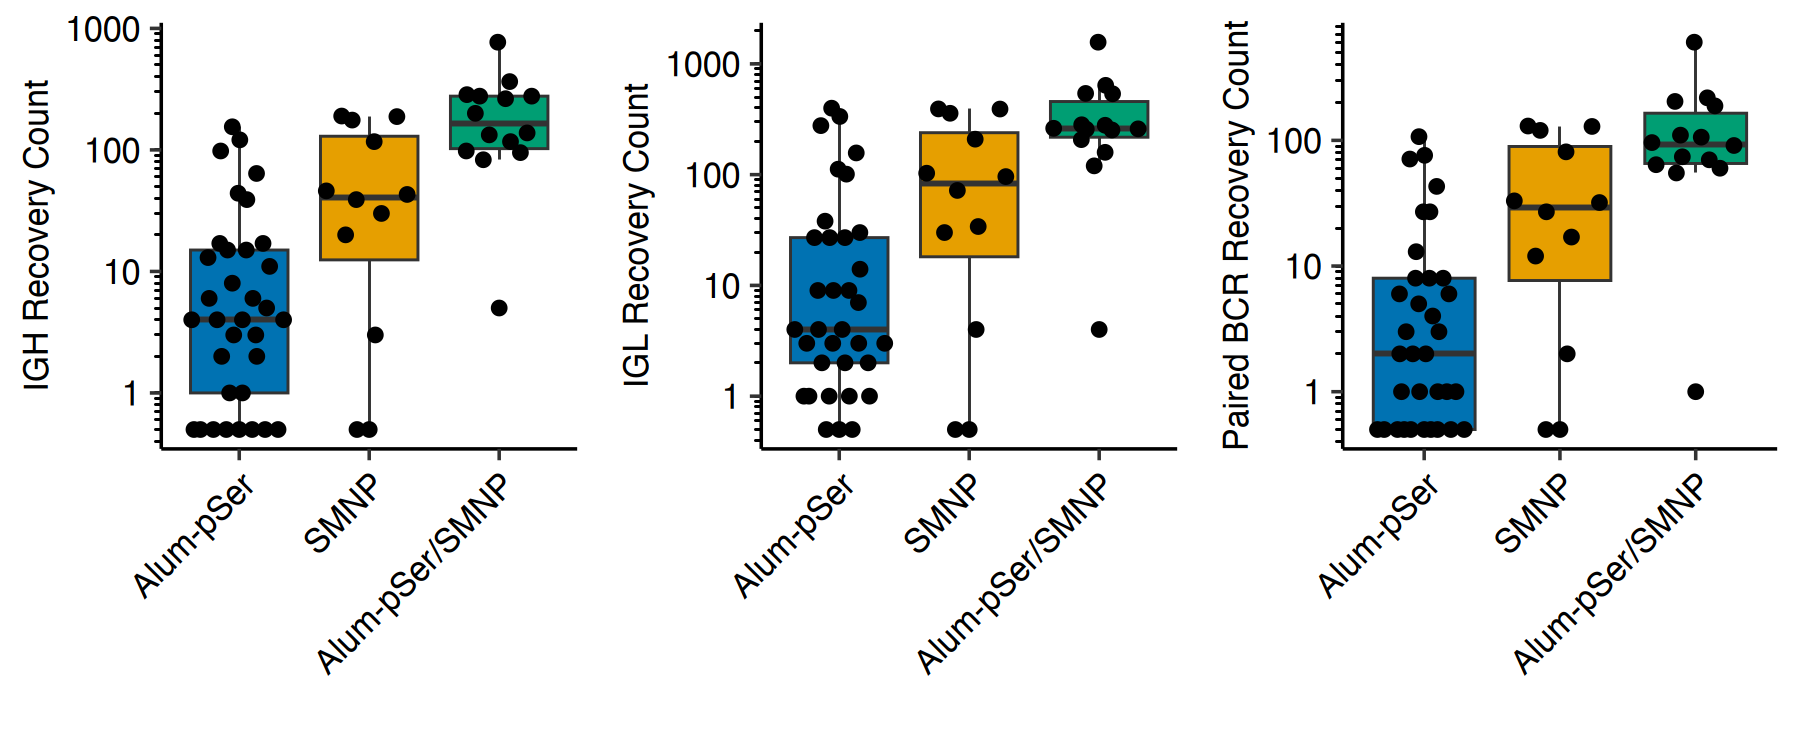

In [27]:
metadata <- srat@meta.data

df4gg = metadata %>% count(group,mouse.id,IGH_recovery) %>% 
mutate(n=as.numeric(n)) %>%
tidyr::complete(tidyr::nesting(group,mouse.id),IGH_recovery) %>% 
replace(is.na(.),0.5) %>% 
filter(IGH_recovery>0) 

p1 = df4gg %>% 
ggplot(aes(x=group,y=n,fill=group)) + theme_classic() + NoLegend()+
geom_boxplot(outlier.shape = NA, size=0.25) +
geom_quasirandom(size=1)+
scale_fill_manual(values=group.col)+
labs(x = '', y = 'IGH Recovery Count') +
scale_y_log10()+
Axis_themes + 
annotation_logticks(sides = "l", outside = TRUE, linewidth=0.25,
                    short = unit(.5, "mm"),mid = unit(.5, "mm"),long = unit(.5, "mm")) +
coord_cartesian(clip = "off")  # Ticks outside plot

df4gg = metadata %>% count(group,mouse.id,IGL_recovery) %>% 
mutate(n=as.numeric(n)) %>%
tidyr::complete(tidyr::nesting(group,mouse.id),IGL_recovery) %>% 
replace(is.na(.),0.5) %>% 
filter(IGL_recovery>0) 

p2 = df4gg %>% 
ggplot(aes(x=group,y=n,fill=group)) + theme_classic() + NoLegend()+
geom_boxplot(outlier.shape = NA, size=0.25) +
geom_quasirandom(size=1)+
scale_fill_manual(values=group.col)+
labs(x = '', y = 'IGL Recovery Count') +
scale_y_log10()+
Axis_themes + 
annotation_logticks(sides = "l", outside = TRUE, linewidth=0.25,
                    short = unit(.5, "mm"),mid = unit(.5, "mm"),long = unit(.5, "mm")) +
coord_cartesian(clip = "off")  # Ticks outside plot

df4gg = metadata %>% count(group,mouse.id,recovery) %>% 
mutate(n=as.numeric(n)) %>%
tidyr::complete(tidyr::nesting(group,mouse.id),recovery) %>% 
replace(is.na(.),0.5) %>% 
filter(recovery==3) 

p3 = df4gg %>% 
ggplot(aes(x=group,y=n,fill=group)) + theme_classic() + NoLegend()+
geom_boxplot(outlier.shape = NA, size=0.25) +
geom_quasirandom(size=1)+
scale_fill_manual(values=group.col)+
labs(x = '', y = 'Paired BCR Recovery Count') +
scale_y_log10()+
Axis_themes+ 
annotation_logticks(sides = "l", outside = TRUE, linewidth=0.25,
                    short = unit(.5, "mm"),mid = unit(.5, "mm"),long = unit(.5, "mm")) +
coord_cartesian(clip = "off")  # Ticks outside plot

options(repr.plot.height=2.5,repr.plot.width=6,repr.plot.res=300)
cowplot::plot_grid(p1, p2, p3, ncol = 3)

out = 'figures/fig3/boxplot_recovery.pdf'
ggsave(out,device='pdf', height = 2.5, width = 6,
       dpi = 300,useDingbats = FALSE)

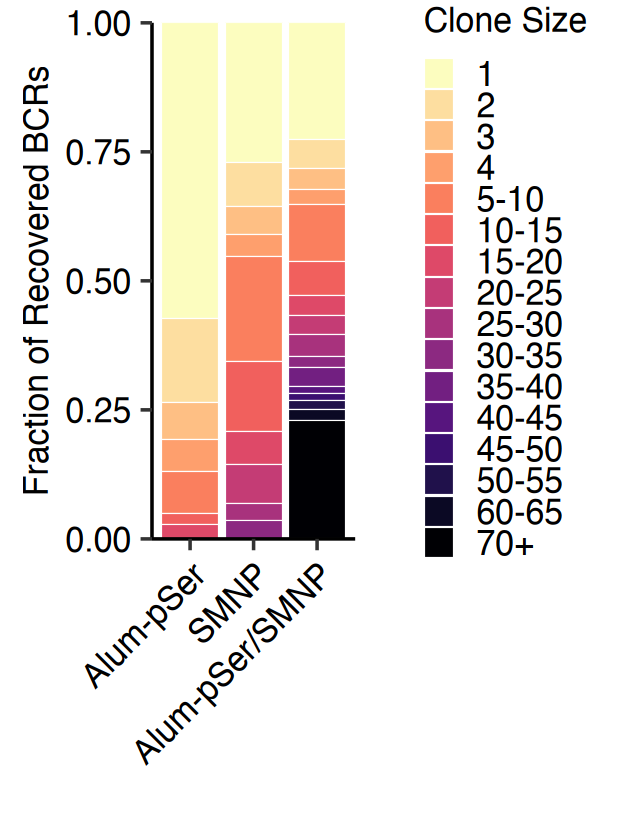

In [22]:
options(repr.plot.height=2.8,repr.plot.width=2.1,repr.plot.res=300)

metadata <- srat@meta.data %>% filter(CLONE > 0)

count <- countClones(metadata, clone = 'CLONE')
metadata$clonal.size <- count$seq_count[match(metadata$CLONE, count$CLONE)]

metadata <- metadata %>%
  filter(IGH_ISOTYPE != 'NA') %>%
  mutate(bin = cut(clonal.size, breaks = c(0, 1, 2, 3, seq(4, 70, 5), 600),
                   include.lowest = TRUE,
                   labels = c(1,2,3,4,paste(seq(5, 65, 5), seq(10, 70, 5), sep = "-"), "70+")))

metadata %>%
ggplot(aes(x = group, fill = bin)) + theme_classic() +
geom_bar(position = 'fill', color = 'white', linewidth = 0.1) +
labs(x = '', y = 'Fraction of Recovered BCRs', fill = 'Clone Size') +

scale_fill_viridis(discrete = TRUE, direction = -1, option = 'magma', na.value = 'grey') +
guides(fill = guide_legend(keywidth = 0.5, keyheight = 0.2, ncol = 1)) +
scale_y_continuous(expand = c(0, 0)) +
Axis_themes

# out = 'figures/fig3/barplot_clone_size.pdf'
# ggsave(out,device='pdf', height = 2.8, width = 2.1,
#        dpi = 300,useDingbats = FALSE)


In [27]:
# How many clones greater than 10? 
metadata %>% count(group,CLONE) %>% filter(n>10) %>% 
group_by(group) %>% summarise(n())

group          n()
1 Alum-pSer       2 
2 SMNP           16 
3 Alum-pSer/SMNP 42

`summarise()` has grouped output by 'group', 'mouse.id'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = div ~ group, data = df4gg)

$group
                                diff        lwr         upr     p adj
SMNP-Alum-pSer           -0.04808198 -0.1530680  0.05690405 0.5049370
Alum-pSer/SMNP-Alum-pSer -0.17132297 -0.2666336 -0.07601231 0.0003191
Alum-pSer/SMNP-SMNP      -0.12324098 -0.2264820 -0.01999999 0.0165560


Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                  Comparison         Z      P.unadj        P.adj
1 Alum-pSer - Alum-pSer/SMNP -4.177572 2.946369e-05 8.839107e-05
2           Alum-pSer - SMNP -1.404332 1.602200e-01 1.602200e-01
3      Alum-pSer/SMNP - SMNP  2.428608 1.515691e-02 2.273536e-02

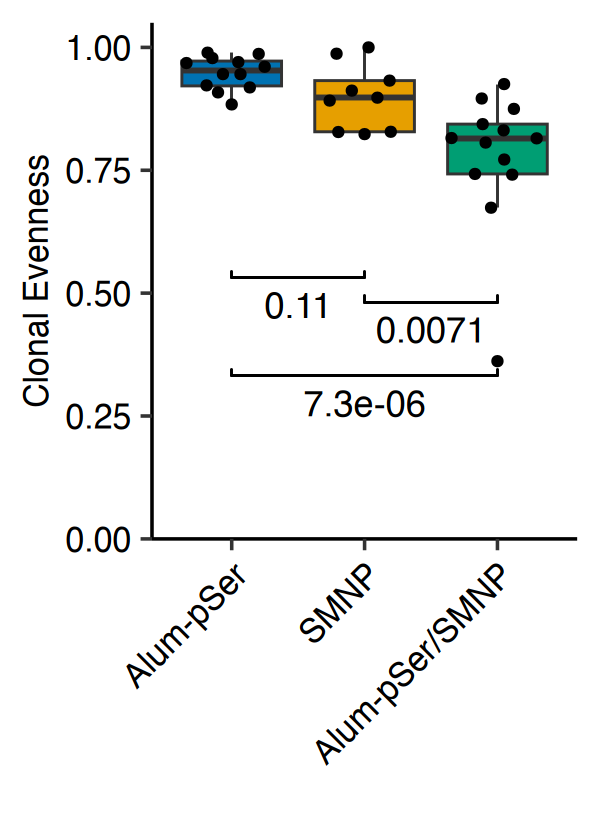

In [28]:
options(repr.plot.width=2, repr.plot.height=2.8,repr.plot.res=300)

metadata = srat@meta.data 

df4gg = metadata %>% filter(CLONE>0) %>% 
group_by(group, mouse.id, CLONE) %>% 
summarize(ncell.clone.mouse = n()) %>% 
mutate(ncell.mouse = sum(ncell.clone.mouse)) %>% 
filter(ncell.mouse>=10) %>% # remove mouse with less than 5 bcrs
summarize(div = vegan::diversity(ncell.clone.mouse, base=n()),ncell.mouse = sum(ncell.clone.mouse)) 

df4gg %>% 
ggplot(aes(x=group, y=div, fill=group)) + theme_classic()+ NoLegend()+
geom_boxplot(outlier.shape=NA,size=0.25) + 
geom_quasirandom(size=0.5) + 

scale_fill_manual(values=group.col) +
stat_compare_means(method = "wilcox.test",label = 'p.format',label.y=c(0.5,0.45,0.3),vjust=2,
                   tip.length = -0.02,size=3,comparisons=my.comparison, bracket.size=0.25)+
#stat_compare_means(method = "kruskal.test", size=3, label.y=0.1)+
labs(y='Clonal Evenness', x='') + 
scale_y_continuous(limits=c(0,1.05),expand =c(0,0)) +
Axis_themes

TukeyHSD(aov(div ~ group,data=df4gg))
FSA::dunnTest((1-div) ~ group,
         data= df4gg , 
         method="bh")

# out = 'figures/fig3/Clone_evenness_boxplot.pdf'
# ggsave(out,device='pdf', height = 2.8, width = 2,
#        dpi = 300,useDingbats = FALSE)



In [18]:
metadata = srat@meta.data

df4gg = metadata %>% filter(CLONE>0) %>% 
group_by(group, mouse.id, CLONE) %>% summarize(ncell.clone = n()) %>% 
summarize(richness = n(),ncell.mouse = sum(ncell.clone)) #%>% filter(ncell.mouse >= 10)

df4gg2 = df4gg %>% group_by(group) %>% 
mutate(mean.richness = mean(richness), std = sd(richness), se = std / sqrt(n()) ) %>% 
select(group,mean.richness,std,se) %>% unique() 

`summarise()` has grouped output by 'group', 'mouse.id'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


`summarise()` has grouped output by 'group', 'mouse.id'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.
Warning message in wilcox.test.default(c(1.07918124604762, 1.11394335230684, 1.51851393987789, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1.07918124604762, 1.11394335230684, 1.51851393987789, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1.68124123737559, 1.82607480270083, 1.44715803134222, :
“cannot compute exact p-value with ties”
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                  Comparison          Z     P.unadj       P.adj
1 Alum-pSer - Alum-pSer/SMNP -3.2209955 0.001277462 0.003832385
2           Alum-pSer - SMNP -0.4018124 0.687822087 0.687822087
3      Alum-pSer/SMNP - SMNP  2.5649744 0.010318341 0.015477512

Warning message in wilcox.test.default(c(1.07918124604762, 1.11394335230684, 1.51851393987789, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1.07918124604762, 1.11394335230684, 1.51851393987789, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1.68124123737559, 1.82607480270083, 1.44715803134222, :
“cannot compute exact p-value with ties”


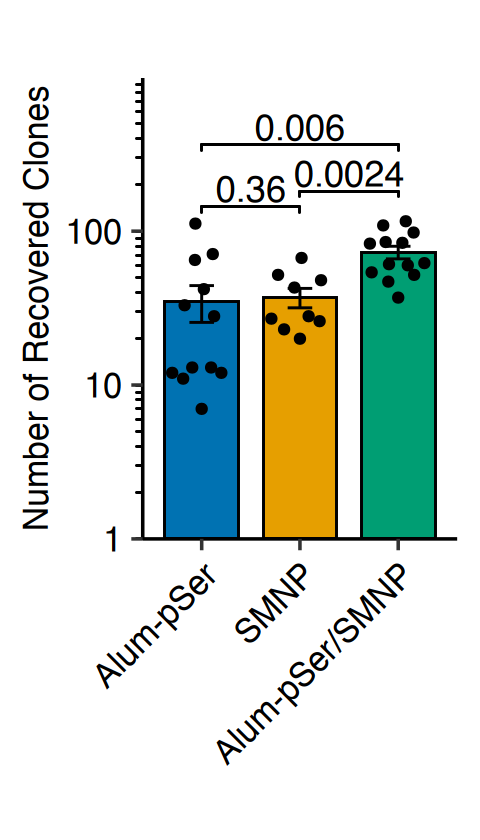

In [23]:
options(repr.plot.width=1.6, repr.plot.height=2.8,repr.plot.res=300)

metadata = srat@meta.data

# calculate fraction 
df4gg = metadata %>% filter(CLONE>0) %>% 
group_by(group, mouse.id, CLONE) %>% summarize(ncell.clone = n()) %>% 
summarize(richness = n(),nbcr.mouse = sum(ncell.clone))

# add ncell.mouse info
ncell.mouse= metadata %>% count(group,mouse.id,name = 'ncell')
ncell.mouse = ncell.mouse %>% filter(mouse.id %in% df4gg$mouse.id)
df4gg$ncell = ncell.mouse$ncell[match(df4gg$mouse.id,ncell.mouse$mouse.id)]

df4gg =df4gg %>% filter(ncell>10, nbcr.mouse>=10) 
df4gg2 = df4gg %>% group_by(group) %>% 
mutate(mean.richness = mean(richness), std = sd(richness), se = std / sqrt(n()) ) %>% 
select(group,mean.richness,std,se) %>% unique() 

df4gg %>% 
ggplot(aes(x=group, y=richness, fill=group)) + theme_classic()+ NoLegend()+
geom_bar(data = df4gg2, aes(x=group,y=mean.richness,fill=group),
         stat='identity',color='black',width=0.75,linewidth = 0.25) + 
geom_errorbar(data = df4gg2, width = 0.25,linewidth = .25,
              aes(x=group,y=mean.richness,ymin=mean.richness - se, ymax=mean.richness + se)) + 
#geom_boxplot(outlier.shape=NA, size=0.25) + 
geom_quasirandom(size=0.5) + 
scale_fill_manual(values=group.col) +
scale_y_log10(expand =c(0,0),limits=c(1,990))+
stat_compare_means(method = "wilcox.test",label = 'p.format',size=3,comparisons=my.comparison,
                   label.y.npc='top', bracket.size=0.25, label.y=c(2.1,2.2,2.5))+
#stat_compare_means(method = "kruskal.test", size=2.5, label.y=2.8)+
scale_color_gradient(low = "black", high = "grey80")+ 
labs(y='Number of Recovered Clones', x='', title='') + 
Axis_themes + 
annotation_logticks(sides = "l", outside = TRUE, linewidth=0.25,
                    short = unit(.5, "mm"),mid = unit(.5, "mm"),long = unit(.5, "mm")) +
coord_cartesian(clip = "off")  # Ticks outside plot

FSA::dunnTest(richness ~ group,data= df4gg ,method="bh")

out = 'figures/fig3/barplot_clonal_richness_by_mouse.pdf'
ggsave(out,device='pdf', height = 2.8, width = 1.6,
       dpi = 300,useDingbats = FALSE)


`summarise()` has grouped output by 'group', 'mouse.id'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'group', 'mouse.id'. You can override using
the `.groups` argument.


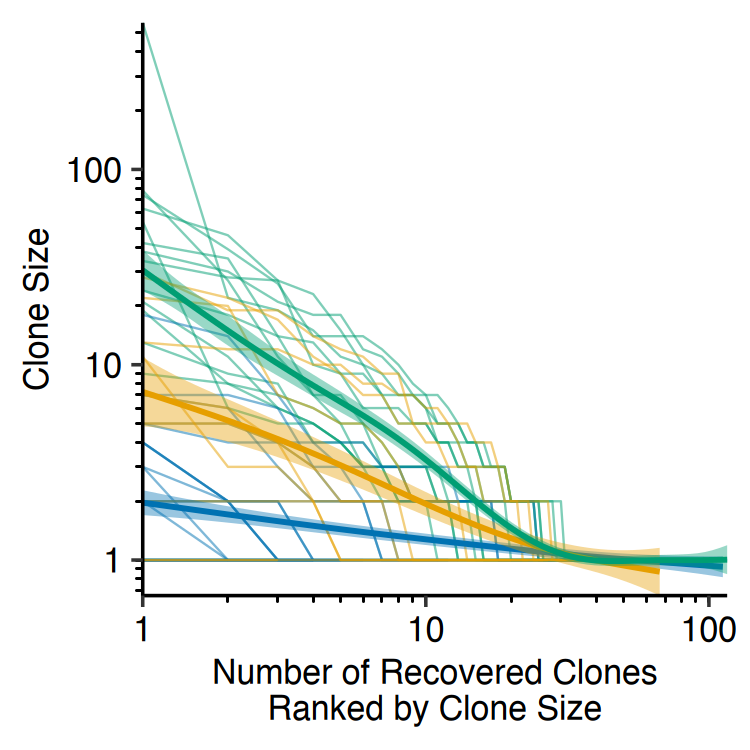

In [25]:
options(repr.plot.width=2.5, repr.plot.height=2.5,repr.plot.res=300)

metadata = srat@meta.data %>% filter(CLONE>0) #%>% filter(!startsWith(mouse.id,'P1')) 

df4gg = metadata %>% group_by(group,mouse.id,CLONE) %>% 
summarize(ncell.clone=n()) %>% ungroup()%>%
arrange(group,desc(ncell.clone))%>% 
group_by(group,mouse.id) %>% mutate(rank = row_number())
df4gg$group.mouse = paste(df4gg$group,df4gg$mouse.id, sep='_')

#configure the colors 
df4gg = df4gg %>% 
mutate(col = ifelse(group=='Alum-pSer','#0072B2',ifelse(group=='SMNP','#E69F00','#009E73')))
col = df4gg$col
names(col) = df4gg$group.mouse
col = c(col,group.col)

# total 
df4gg2 = metadata %>% group_by(group,mouse.id,CLONE) %>% summarize(ncell.clone=n()) %>% ungroup() %>%
arrange(group,desc(ncell.clone))%>% group_by(group) %>% mutate(rank = row_number())

df4gg %>% 
ggplot(aes(x=rank,y=ncell.clone)) + theme_classic()+ NoLegend()+
#geom_line(data = df4gg2, aes(x=rank,y=ncell.clone,color=group),linetype='solid',linewidth = 0.5) + 
geom_line(aes(color=group.mouse),linetype=1,linewidth = 0.2,alpha=0.5) + 
geom_smooth(aes(color=group,fill=group),method = "gam", formula = y ~ s(x),
            se = TRUE,level=0.99,linewidth=0.5)+ 
scale_y_log10(expand=c(0,0)) + scale_x_log10(expand=c(0,0)) +
scale_color_manual(values=col) +
scale_fill_manual(values=group.col) +
labs(x='Number of Recovered Clones\nRanked by Clone Size',y='Clone Size')+
Axis_themes+
theme(axis.text.x=element_text(angle=0, hjust=0.5))+ 
annotation_logticks(sides = "bl", outside = TRUE, linewidth=0.25,
                    short = unit(.5, "mm"),mid = unit(.5, "mm"),long = unit(.5, "mm")) +
coord_cartesian(clip = "off")  # Ticks outside plot

out = 'figures/fig3/clonesize_vs_richness_lineplot_fit.pdf'
ggsave(out,device='pdf', height = 2.5, width = 2.5,
       dpi = 300,useDingbats = FALSE)


Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                  Comparison          Z      P.unadj        P.adj
1 Alum-pSer - Alum-pSer/SMNP   0.871247 3.836193e-01 3.836193e-01
2           Alum-pSer - SMNP  -7.092511 1.317003e-12 1.975504e-12
3      Alum-pSer/SMNP - SMNP -10.466319 1.233460e-25 3.700381e-25

Warning message:
“Some rows deleted from 'x' and 'g' because missing data.”
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                  Comparison          Z   P.unadj     P.adj
1 Alum-pSer - Alum-pSer/SMNP -0.9509726 0.3416183 1.0000000
2           Alum-pSer - SMNP -0.4030808 0.6868888 0.6868888
3      Alum-pSer/SMNP - SMNP  0.5333353 0.5938015 0.8907023

Warning message:
“Removed 1671 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 1671 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 1671 rows containing non-finite outside the scale range
(`stat_signif()`).”


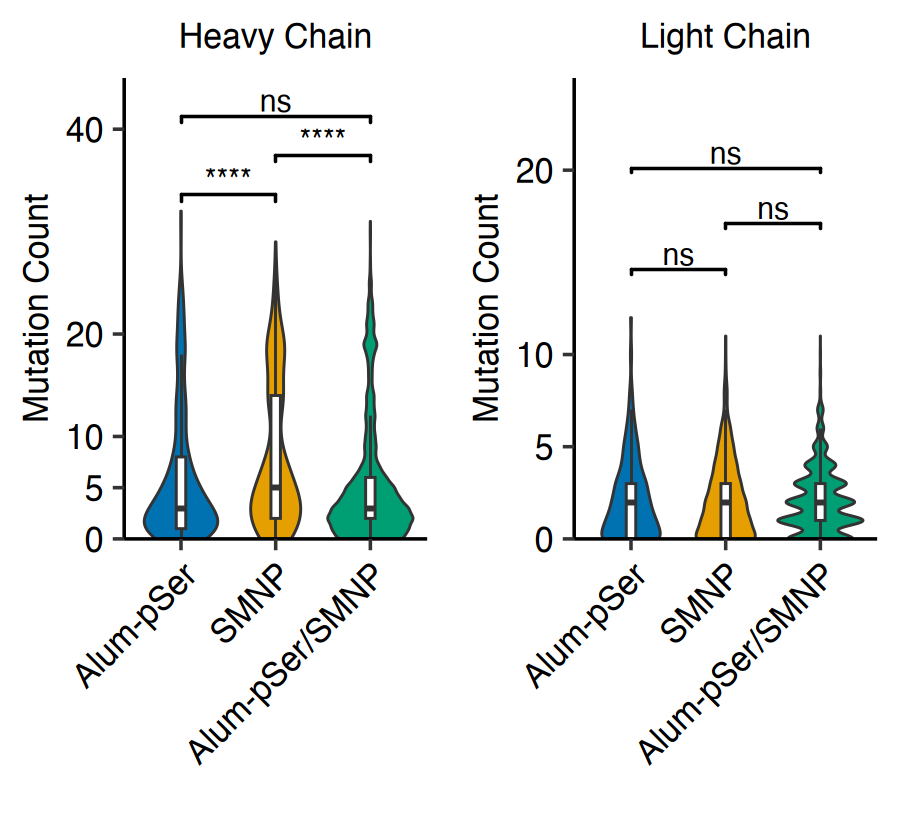

In [48]:
metadata = srat@meta.data %>% filter(IGH_mu_count!='NA')

metadata  %>% 
ggplot(aes(x=group, y=IGH_mu_count)) + theme_classic() + NoLegend()+
geom_violin(aes(fill=group),scale='area',size=0.25) + 
geom_boxplot(width=0.1, outlier.shape=NA,size=0.25)+ 
labs(x='',y='Mutation Count',title='Heavy Chain') + #ylim(0,35)+
scale_fill_manual(values=group.col) +
stat_compare_means(method = "wilcox.test",label = 'p.signif',label.y.npc='top',
                   tip.length = 0.02,comparisons = my.comparison,size=2.5)+
#stat_compare_means(method = "kruskal.test",label.y.npc='top',size=2.5)+
scale_y_continuous(breaks=c(0,5,10,20,40),limits = c(0,45),expand=c(0,0))+
Axis_themes -> p1

FSA::dunnTest(IGH_mu_count ~ group,
         data=metadata,
         method="bh")

metadata  %>% 
ggplot(aes(x=group, y=IGL_mu_count)) + theme_classic() + NoLegend()+
geom_violin(aes(fill=group),scale='area',size=0.25) + 
geom_boxplot(width=0.1, outlier.shape=NA,size=0.25)+ 
labs(x='',y='Mutation Count',title='Light Chain') + #ylim(0,35)+
scale_fill_manual(values=group.col) +
stat_compare_means(method = "wilcox.test",label = 'p.signif',label.y = c(14,16.5,19.5),
                   tip.length = 0.02,comparisons = my.comparison,size=2.5)+
#stat_compare_means(method = "kruskal.test",label.y.npc='top',size=2.5)+
scale_y_continuous(breaks=c(0,5,10,20,40),limits = c(0,25),expand=c(0,0))+
Axis_themes -> p2

FSA::dunnTest(IGL_mu_count ~ group,
         data=metadata,
         method="bh")

options(repr.plot.height=2.8, repr.plot.width=3,repr.plot.res=300)
cowplot::plot_grid(p1,p2)

out = 'figures/fig3/SHM_heavy_light.pdf'
ggsave(out,device='pdf', height = 2.8, width = 3,
       dpi = 300,useDingbats = FALSE)


Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                  Comparison          Z      P.unadj        P.adj
1 Alum-pSer - Alum-pSer/SMNP   0.871247 3.836193e-01 3.836193e-01
2           Alum-pSer - SMNP  -7.092511 1.317003e-12 1.975504e-12
3      Alum-pSer/SMNP - SMNP -10.466319 1.233460e-25 3.700381e-25

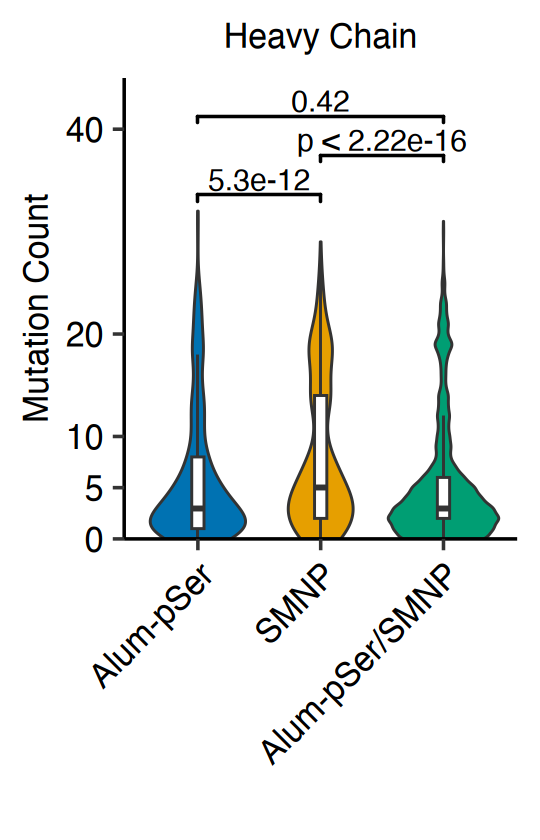

In [35]:
options(repr.plot.height=2.8, repr.plot.width=1.8,repr.plot.res=300)

metadata = srat@meta.data %>% filter(IGH_mu_count!='NA')

metadata  %>% 
ggplot(aes(x=group, y=IGH_mu_count)) + theme_classic() + NoLegend()+
geom_violin(aes(fill=group),scale='area',size=0.25) + 
geom_boxplot(width=0.1, outlier.shape=NA,size=0.25)+ 
labs(x='',y='Mutation Count',title='Heavy Chain') + #ylim(0,35)+
scale_fill_manual(values=group.col) +
stat_compare_means(method = "wilcox.test",label = 'p.format',label.y.npc='top',
                   tip.length = 0.02,comparisons = my.comparison,size=2.5)+
#stat_compare_means(method = "kruskal.test",label.y.npc='top',size=2.5)+
scale_y_continuous(breaks=c(0,5,10,20,40),limits = c(0,45),expand=c(0,0))+
Axis_themes

FSA::dunnTest(IGH_mu_count ~ group,
         data=metadata,
         method="bh")

# out = 'figures/fig3/SHM_heavy.pdf'
# ggsave(out,device='pdf', height = 2.8, width = 1.8,
#        dpi = 300,useDingbats = FALSE)


Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                  Comparison         Z      P.unadj       P.adj
1 Alum-pSer - Alum-pSer/SMNP 0.3357643 0.7370486420 0.737048642
2           Alum-pSer - SMNP 3.0634082 0.0021883130 0.003282469
3      Alum-pSer/SMNP - SMNP 3.4816011 0.0004984256 0.001495277

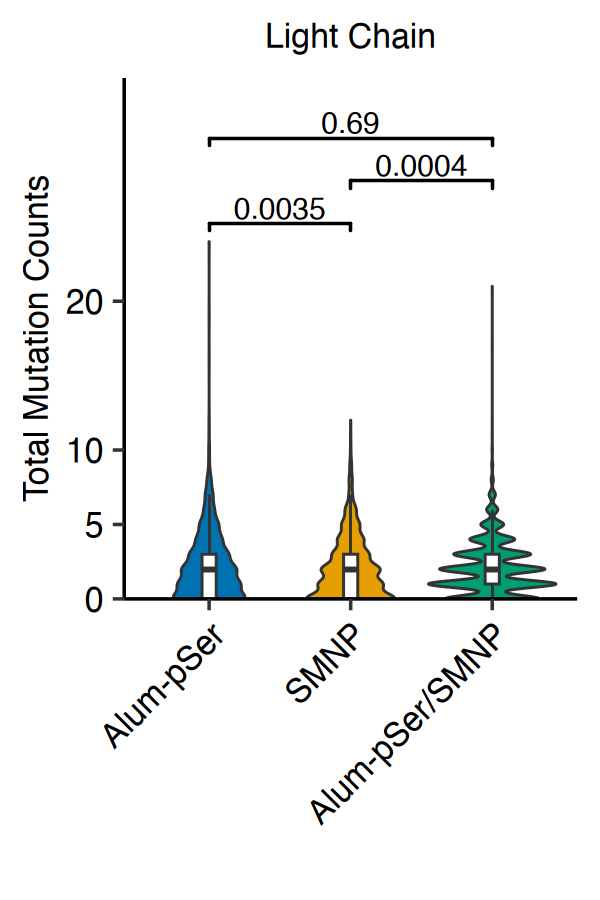

In [64]:
options(repr.plot.height=3, repr.plot.width=2,repr.plot.res=300)

metadata = srat@meta.data %>% filter(IGL_mu_count!='NA')

metadata  %>% 
ggplot(aes(x=group, y=IGL_mu_count)) + theme_classic() + NoLegend()+
geom_violin(aes(fill=group),scale='area',size=0.25) + 
geom_boxplot(width=0.1, outlier.shape=NA,size=0.25)+ 
labs(x='',y='Total Mutation Counts',title='Light Chain') + #ylim(0,35)+
scale_fill_manual(values=group.col) +
stat_compare_means(method = "wilcox.test",label = 'p.format',label.y.npc='top',
                   tip.length = 0.02,comparisons = my.comparison,size=2.5)+
#stat_compare_means(method = "kruskal.test",label.y.npc='top',size=2.5)+
scale_y_continuous(breaks=c(0,5,10,20,40),limits = c(0,35),expand=c(0,0))+
Axis_themes

FSA::dunnTest(IGL_mu_count ~ group,
         data=metadata,
         method="bh")

# out = 'md39/figures/fig3/SHM_heavy.pdf'
# ggsave(out,device='pdf', height = 5, width = 3.5,
#        dpi = 300,useDingbats = FALSE)
# system(paste('gsutil cp',out,'gs://fc-0bb553df-b02d-4bb6-b0aa-f6d779968cff/md39/figures/'))

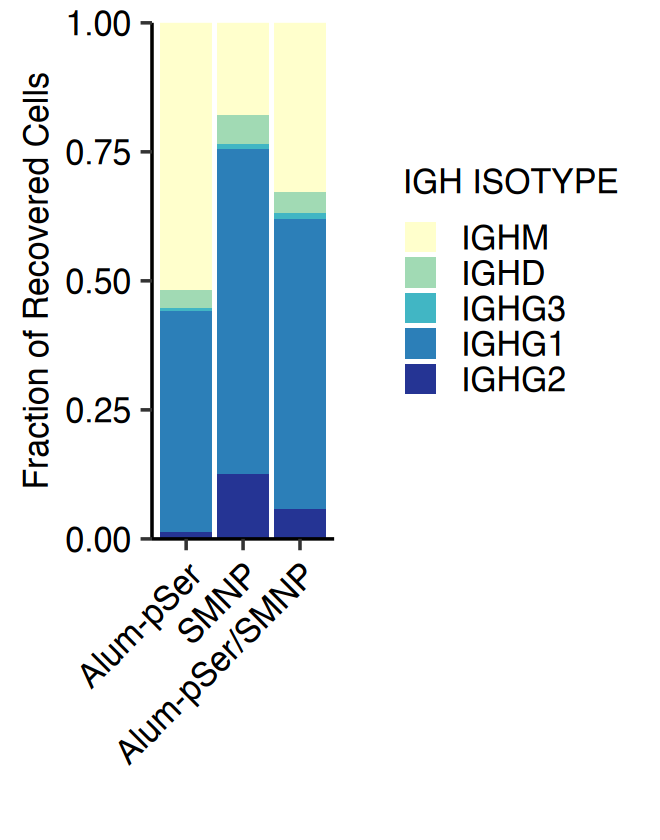

In [52]:
options(repr.plot.height=2.8, repr.plot.width=2.2,repr.plot.res=300)
metadata = srat@meta.data 
metadata$IGH_ISOTYPE[metadata$IGH_ISOTYPE=='IGHD1']='IGHD'
metadata$IGH_ISOTYPE = factor(metadata$IGH_ISOTYPE,levels=c('IGHM','IGHD','IGHG3','IGHG1','IGHG2'))

metadata %>% filter(IGH_ISOTYPE!='NA') %>% 
ggplot(aes(x=group, fill=IGH_ISOTYPE)) + theme_classic() + 
geom_bar(position='fill') + 
scale_fill_brewer(palette = 'YlGnBu',direction=1,na.value="grey")+
labs(x='',y='Fraction of Recovered Cells',fill='IGH ISOTYPE') + 
scale_y_continuous(expand = c(0,0)) +
Axis_themes

out = 'figures/fig3/CSR_heavy.pdf'
ggsave(out,device='pdf', height = 2.8, width = 2.2,
       dpi = 300,useDingbats = FALSE)


Adding missing grouping variables: `IGH_ISOTYPE`
Warning message in wilcox.test.default(c(0, 0, 0, 0, 0, 0, 0.0204081632653061, 0, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0, 0, 0, 0, 0, 0, 0.0204081632653061, 0, :
“cannot compute exact p-value with ties”
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                  Comparison          Z    P.unadj     P.adj
1 Alum-pSer - Alum-pSer/SMNP -1.6610594 0.09670152 0.1450523
2           Alum-pSer - SMNP -1.7649040 0.07757991 0.2327397
3      Alum-pSer/SMNP - SMNP -0.2612683 0.79388557 0.7938856

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                  Comparison          Z     P.unadj       P.adj
1 Alum-pSer - Alum-pSer/SMNP -3.2043787 0.001353543 0.002030315
2           Alum-pSer - SMNP -3.4555384 0.000549195 0.001647585
3      Alum-pSer/SMNP - SMNP -0.5557078 0.578410605 0.578410605

Warning message in wilcox.test.default(c(0, 0, 0, 0, 0, 0, 0.0204081632653061, 0, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0, 0, 0, 0, 0, 0, 0.0204081632653061, 0, :
“cannot compute exact p-value with ties”


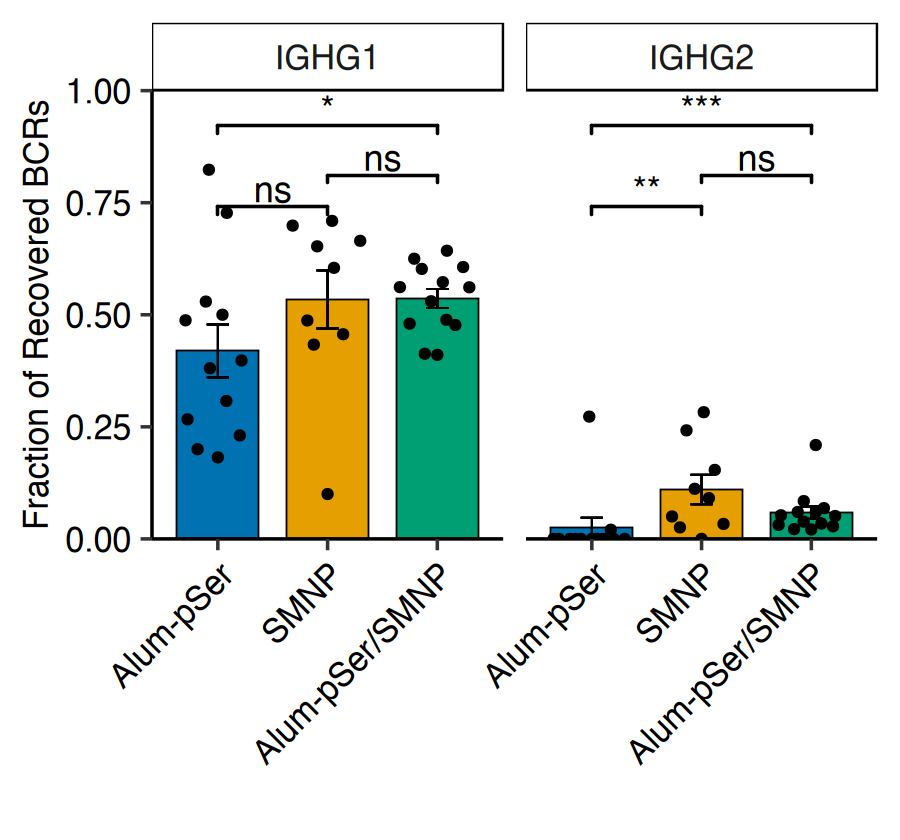

In [61]:
options(repr.plot.width=3,repr.plot.height=2.8,repr.plot.res=300)

metadata = srat@meta.data %>% filter(IGH_ISOTYPE!='NA')

df4gg = metadata %>% count(group, mouse.id, IGH_ISOTYPE) %>% 
tidyr::complete(tidyr::nesting(group, mouse.id), IGH_ISOTYPE) %>% replace(is.na(.),0) %>%
group_by(group, mouse.id) %>% mutate(ncell.mouse = sum(n), frac= n/ncell.mouse) %>% 
filter(ncell.mouse>10, IGH_ISOTYPE %in% c('IGHG1','IGHG2')) %>% ungroup()

df4gg = df4gg %>% group_by(group,IGH_ISOTYPE) %>% 
mutate(mean.frac = mean(frac),se = sd(frac) / sqrt(n()) ) 
df4gg2 = df4gg %>% select(group,mean.frac,se) %>% unique() 

df4gg %>% 
ggplot(aes(x=group,y=frac)) + theme_classic() + NoLegend()+
geom_bar(data = df4gg2, aes(x=group, y=mean.frac, fill=group),stat='identity',
         color='black',width=0.75,linewidth = 0.15) + 
geom_quasirandom(size=0.5) +
geom_errorbar(aes(ymin=mean.frac-se,ymax=mean.frac+se), width = 0.2,linewidth = 0.15) + 
facet_wrap('IGH_ISOTYPE') +
labs(x='',y='Fraction of Recovered BCRs')+ 
scale_fill_manual(values=group.col) +
stat_compare_means(method='wilcox.test',tip.length = 0.02, label = 'p.signif',
                   comparisons = my.comparison,size=3,label.y=c(0.7,0.77,0.88))+ 
#stat_compare_means(method='kruskal.test',tip.length = 0.02,size=2,label.y = 0.7)+  # kruskal.test
scale_y_continuous(limits=c(-0,1),expand =c(0,0)) +
Axis_themes

FSA::dunnTest(frac ~ group,
         data=df4gg %>% filter(IGH_ISOTYPE%in%c('IGHG1')),
         method="bh")
FSA::dunnTest(frac ~ group,
         data=df4gg %>% filter(IGH_ISOTYPE%in%c('IGHG2')),
         method="bh")

out = 'figures/fig3/CSR_by_mouse.pdf'
ggsave(out,device='pdf', height = 2.8, width = 3,
       dpi = 300,useDingbats = FALSE)


In [ ]:
options(repr.plot.width=1.8, repr.plot.height=2.8,repr.plot.res=300)

metadata = srat@meta.data %>% filter(recovery==3) #%>% filter(!mouse.id%in%c('P1_HTO2','P1_HTO7','P2_HTO1')) 

# keep the first light chain v gene when ambiguious 
df = metadata %>% mutate(IGL_V_CALL = str_split_i(IGL_V_CALL,',',1))
dim(df)

# remove allele info 
df = df %>% dplyr::select(group,  mouse.id, CLONE, IGH_GERMLINE_V_CALL,IGL_V_CALL) %>% 
mutate(IGH_GERMLINE_V_CALL = str_split_i(IGH_GERMLINE_V_CALL,'\\*',1), 
       IGL_V_CALL = str_split_i(IGL_V_CALL,'\\*',1))

# if a clone has more than one paired light chain, keep the light chain with greater 
# number of cells in the clone 
df = df %>% group_by(group,mouse.id,CLONE,IGH_GERMLINE_V_CALL,IGL_V_CALL) %>% 
summarize(nigl.clone = n()) %>% mutate(ncell.clone=sum(nigl.clone)) %>%
arrange(desc(nigl.clone)) %>% dplyr::slice(1) %>% ungroup()

# remove mice with low recovered bcrs
df = df %>% group_by(group,mouse.id) %>% mutate(ncell.mouse=sum(ncell.clone)) %>% filter(ncell.mouse>2)

# calculate the pairing diversity 
df4gg = df %>% group_by(group, mouse.id, IGH_GERMLINE_V_CALL,IGL_V_CALL) %>% 
    summarize(npairing=n()) %>% ungroup() %>% group_by(group,mouse.id) %>%
    summarize(div=vegan::diversity(npairing))
df4gg2 = df4gg %>% group_by(group) %>% summarize(avg=mean(div),std = sd(div), se=std/sqrt(avg))

df4gg %>% 
ggplot(aes(x=group,y=div,fill=group)) + theme_classic()+ NoLegend()+
geom_boxplot(outlier.shape=NA, size=0.25) + 
geom_quasirandom(size=1,color='black') +
scale_fill_manual(values=group.col) +
#stat_compare_means(method = "kruskal.test", size=3, label.y=5.8)+ 
stat_compare_means(method = "wilcox.test",label = 'p.format',bracket.size = 0.25,
                   tip.length = 0.04,comparisons = my.comparison, size=3)+
scale_y_continuous(limits = c(0.5, 6.5), expand=c(0,0)) + 
labs(y='Pairing Diversity', x='') + 
Axis_themes

# TukeyHSD(aov(div ~ group,data=df4gg))
FSA::dunnTest(div~group,data= df4gg,method="bh")

out = 'figures/fig3/ig_diversity_errorbars.pdf'
ggsave(out,device='pdf', height = 2.8, width = 1.8,
       dpi = 300,useDingbats = FALSE)


In [66]:
library(circlize)

circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




In [67]:
jz.chordDiagram = function(df,GROUP='all',by.clone=TRUE,expanded=TRUE,font.size=0.5,title.size=0.6) {
    # get colors 
    my.colors = c(df$IGH_COLOR, df$IGL_COLOR)
    names(my.colors) = c(df$IGH_GERMLINE_V_CALL, df$IGL_V_CALL)
    
    # filter by group 
    if (GROUP=='all') {
        a = df %>% mutate(group=as.character(group))
        group = ''
    } else {
        a = df %>% filter(group %in% GROUP) 
    }
    
    # collapse clones 
    if (by.clone) {
        title = 'by Clones'
        if (expanded) {
            # keep expanded clones only 
            a = a %>% filter(clonal.size>1) 
            title = 'of Expanded Clones'
        }
        # if a clone has more than one paired light chain, keep the light chain with greater 
        # number of cells in the clone 
        a = a %>% group_by(group,CLONE,IGH_GERMLINE_V_CALL,IGL_V_CALL)%>% 
        summarize(nigl.clone = n()) %>% mutate(ncell.clone=sum(nigl.clone)) %>%
        arrange(desc(nigl.clone)) %>% dplyr::slice(1) %>% ungroup() 
    } else {
        title='by Cells'
    }
    
    # calculate pairing diversity 
    pairing = a %>% group_by(group,IGH_GERMLINE_V_CALL,IGL_V_CALL) %>% 
    summarize(npairing=n()) %>% ungroup()%>% group_by(group) %>%
    summarize(div=vegan::diversity(npairing))

    circos.par(start.degree = -90,circle.margin = 0.1) # make it left and right symmetry 
    a$value=1
    # draw chord diagram 
    df4circa = a %>% dplyr::select(c(IGH_GERMLINE_V_CALL, IGL_V_CALL, value)) %>% arrange(IGH_GERMLINE_V_CALL)
    chordDiagram(df4circa, grid.col = my.colors, annotationTrack = c("grid"), 
                 preAllocateTracks = 1,transparency = 0.4)
    #title(main = sprintf('%s %s Ig-Pairing %s (n=%d)',group,pheno,title,nrow(a)),cex = title.size)
    title(main = sprintf('%s pairing diveristy: %.2f',GROUP, pairing$div ),cex = title.size)
    text(0,1.1,sprintf("%d Unique Clones",nrow(a) ),cex = 3*title.size)
    
    # add label 
    circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
        xlim = get.cell.meta.data("xlim")
        ylim = get.cell.meta.data("ylim")
        sector.name = get.cell.meta.data("sector.index")
        circos.text(mean(xlim), ylim[1] + .1, sector.name, facing = "clockwise", niceFacing = TRUE, 
                  adj = c(0, 0.5),cex = font.size)
#         circos.axis(h = "top", labels.cex = 0.5, major.tick.length = 0.2, sector.index = sector.name, 
#                   track.index = 2)
    }, bg.border = NA)
    
    circos.clear()
}


In [118]:
metadata = srat@meta.data %>% filter(recovery ==3) 
count = countClones(metadata,clone='CLONE')
metadata$clonal.size=count$seq_count[match(metadata$CLONE,count$CLONE)]

# keep the first light chain v gene when ambiguious 
df4circa = metadata %>% mutate(IGL_V_CALL = str_split_i(IGL_V_CALL,',',1))
dim(df4circa)

# remove allele info 
df4circa = df4circa %>% dplyr::select(group, mouse.id, CLONE, IGH_GERMLINE_V_CALL,IGL_V_CALL,clonal.size)
df4circa = df4circa %>% mutate(IGH_GERMLINE_V_CALL = str_split_i(IGH_GERMLINE_V_CALL,'\\*',1), 
                               IGL_V_CALL = str_split_i(IGL_V_CALL,'\\*',1))

# specify colors 
color = grDevices::colors()
color = color[grep('gr(a|e)y', color, invert = T)]
color = color[grep('white', color, invert = T)]

seed = sample(1:10000, 1)
print(seed)
#set.seed(seed)
set.seed(680)
hc.color = df4circa %>% group_by(IGH_GERMLINE_V_CALL) %>% summarize(count=n()) %>% mutate(COLOR=sample(color,n()))

seed = sample(1:10000, 1)
print(seed)
#set.seed(seed)
set.seed(7668)
lc.color = df4circa %>% group_by(IGL_V_CALL) %>% summarize(count=n()) %>% mutate(COLOR=sample(color,n()))

df4circa$IGH_COLOR = hc.color$COLOR[match(df4circa$IGH_GERMLINE_V_CALL,hc.color$IGH_GERMLINE_V_CALL)]
df4circa$IGL_COLOR = lc.color$COLOR[match(df4circa$IGL_V_CALL,lc.color$IGL_V_CALL)]

[1] 2950   44

[1] 680
[1] 7668


`summarise()` has grouped output by 'group', 'CLONE', 'IGH_GERMLINE_V_CALL'.
You can override using the `.groups` argument.
`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


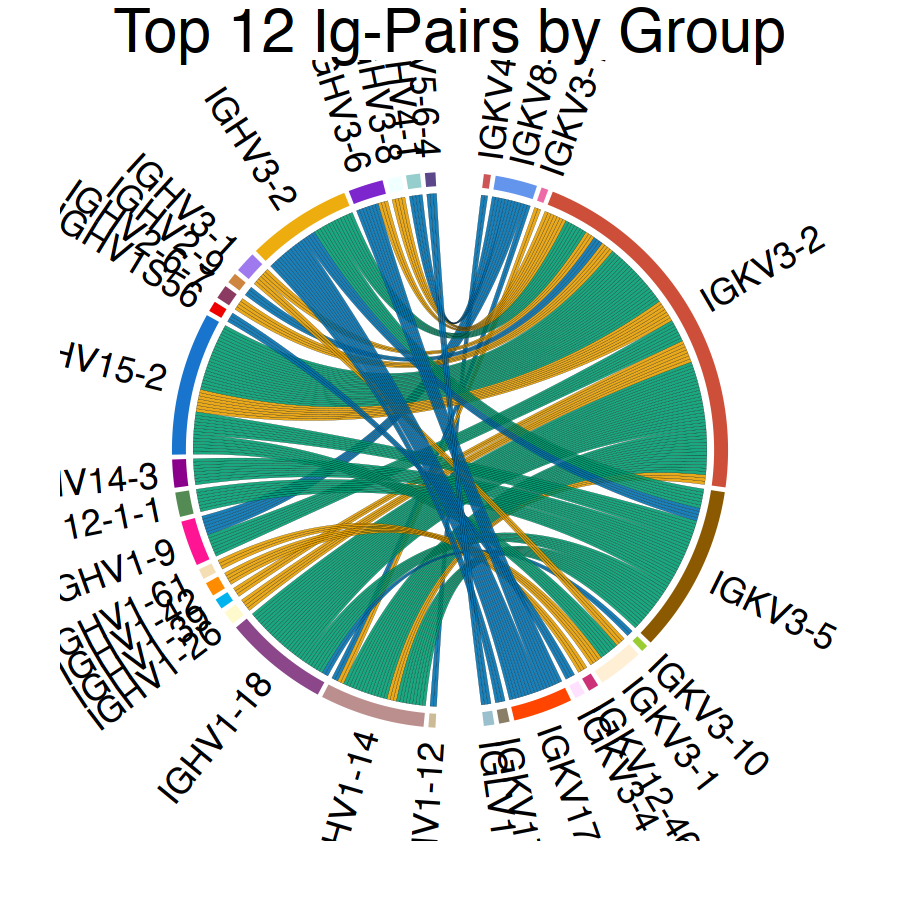

In [119]:
options(repr.plot.height=3, repr.plot.width=3,repr.plot.res=300)
a = df4circa 
# get colors 
gene.colors = c(a$IGH_COLOR, a$IGL_COLOR)
names(gene.colors) = c(a$IGH_GERMLINE_V_CALL, a$IGL_V_CALL)
group.colors.df = data.frame(group=c('Alum-pSer','SMNP','Alum-pSer/SMNP'), col = c('#0072B2','#E69F00','#009E73'))

# collapse clones 
# if a clone has more than one paired light chain, keep the light chain with greater 
# number of cells in the clone
a = a %>% group_by(group,CLONE,IGH_GERMLINE_V_CALL,IGL_V_CALL)%>% 
    summarize(nigl.clone = n()) %>% mutate(ncell.clone=sum(nigl.clone)) %>%
    arrange(desc(nigl.clone)) %>% dplyr::slice(1) %>% ungroup() %>% 
    mutate(pair=paste(IGH_GERMLINE_V_CALL,IGL_V_CALL,sep='_')) %>% 
    mutate(ident = paste(group,pair,sep='_'))

pairs2plot = a %>% group_by(group,pair) %>% summarise(count=n()) %>% arrange(desc(count)) %>% 
slice(1:12) %>% mutate(ident = paste(group,pair,sep='_'))
a = a %>% filter(ident %in% pairs2plot$ident)

circos.par(start.degree = -90) # make it left and right symmetry ,circle.margin = 0.1
a$value=1

# order by igh genes 
b = a %>% dplyr::select(c(IGH_GERMLINE_V_CALL, IGL_V_CALL, value,group)) %>% arrange(IGH_GERMLINE_V_CALL,group)

# make a color vector
link.color = b %>% dplyr::select(group) 
link.color$col = group.colors.df$col[match(link.color$group,group.colors.df$group)]

# make a outline vector 
link.outline = b %>% dplyr::select(group)
link.outline$border='black'

# draw chord diagram 
chordDiagram(b, grid.col = gene.colors, col=link.color$col, annotationTrack = c("grid"), 
             link.lwd = 0.05, link.border = link.outline$border,
             preAllocateTracks = 1,transparency = 0.1)
title(main ='Top 12 Ig-Pairs by Group',cex = 0.3)

# add label 
circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
    xlim = get.cell.meta.data("xlim")
    ylim = get.cell.meta.data("ylim")
    sector.name = get.cell.meta.data("sector.index")
    circos.text(mean(xlim), ylim[1] + .1, sector.name, facing = "clockwise", niceFacing = TRUE, 
              adj = c(0, 0.5),cex = 0.7)
#         circos.axis(h = "top", labels.cex = 0.5, major.tick.length = 0.2, sector.index = sector.name, 
#                   track.index = 2)
}, bg.border = NA)
circos.clear()

`summarise()` has grouped output by 'group', 'CLONE', 'IGH_GERMLINE_V_CALL'.
You can override using the `.groups` argument.
`summarise()` has grouped output by 'group', 'IGH_GERMLINE_V_CALL'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'group', 'CLONE', 'IGH_GERMLINE_V_CALL'.
You can override using the `.groups` argument.
`summarise()` has grouped output by 'group', 'IGH_GERMLINE_V_CALL'. You can
override using the `.groups` argument.


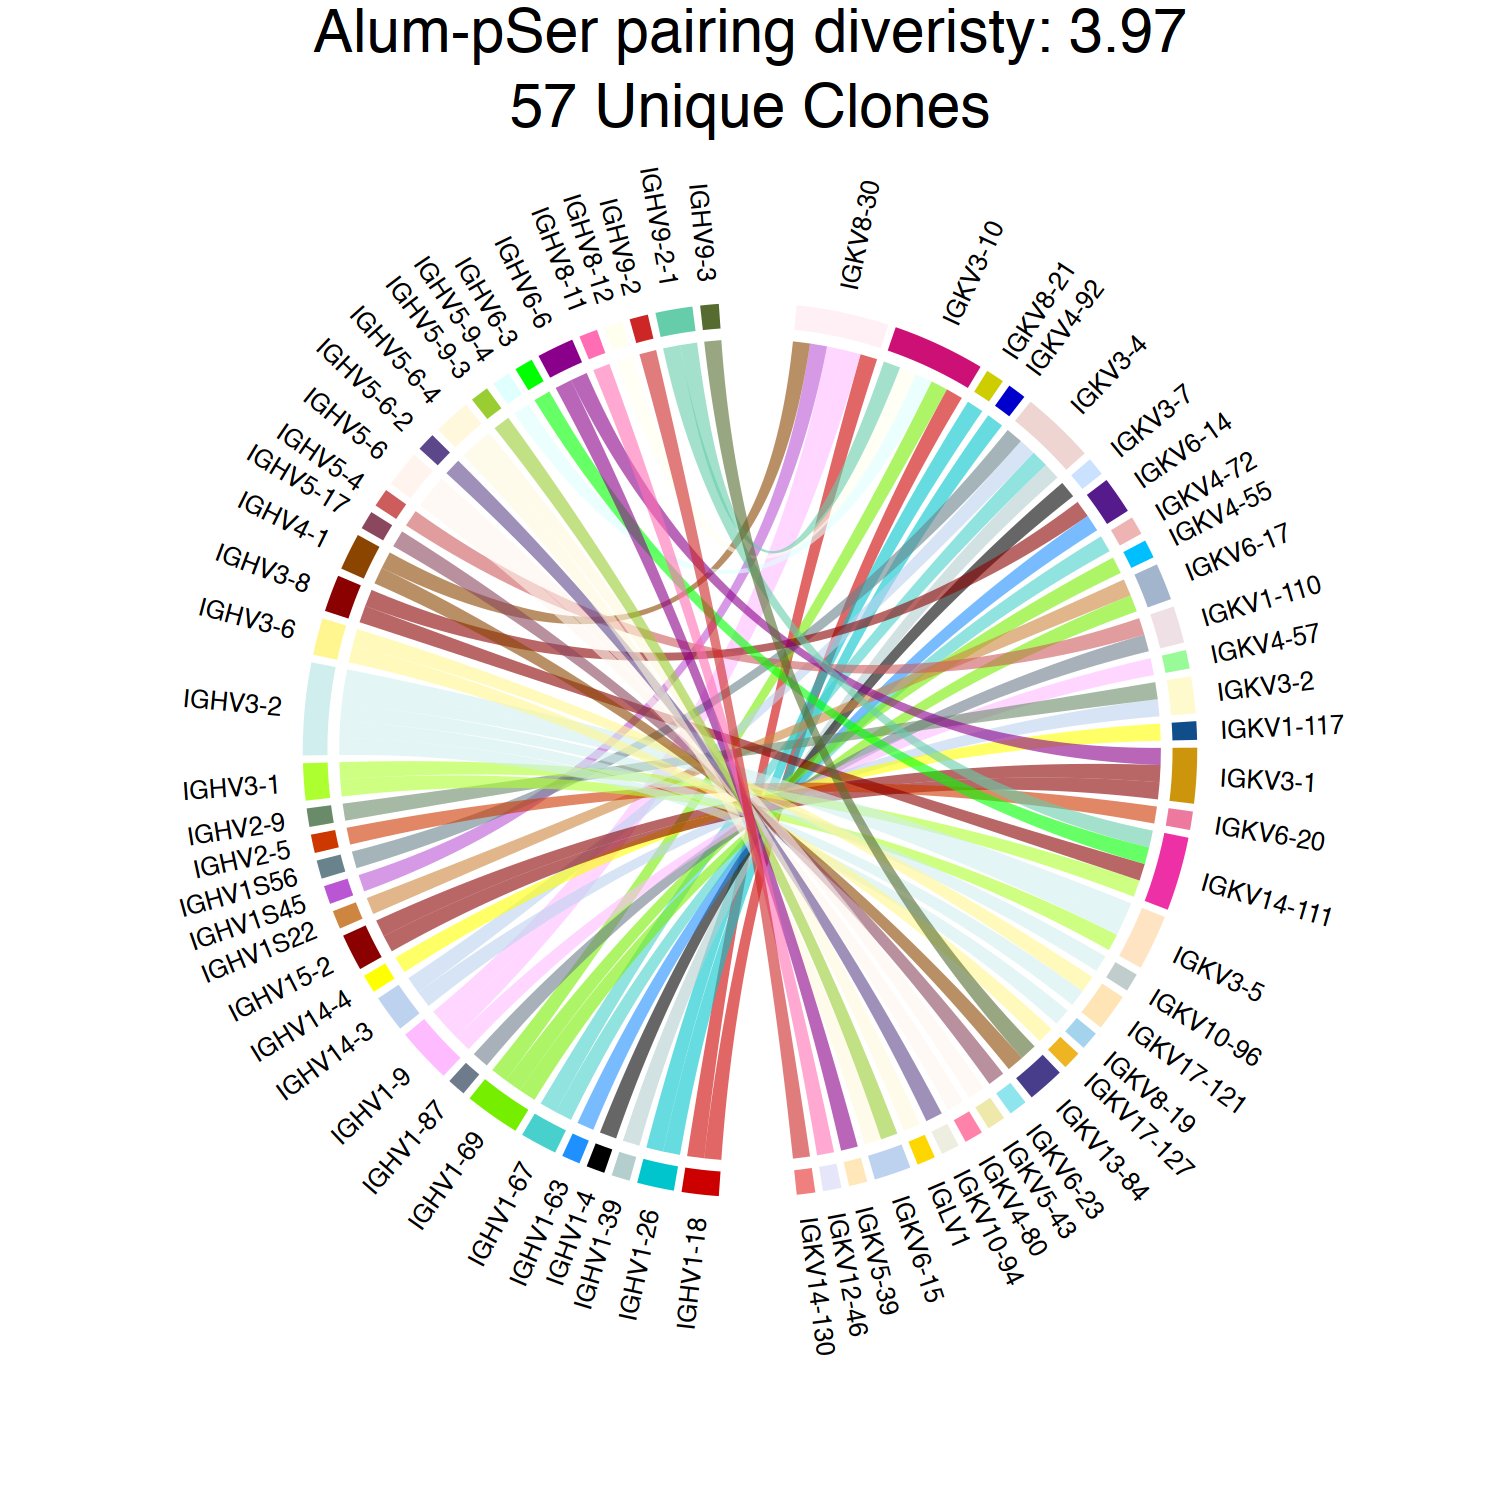

`summarise()` has grouped output by 'group', 'CLONE', 'IGH_GERMLINE_V_CALL'.
You can override using the `.groups` argument.
`summarise()` has grouped output by 'group', 'IGH_GERMLINE_V_CALL'. You can
override using the `.groups` argument.


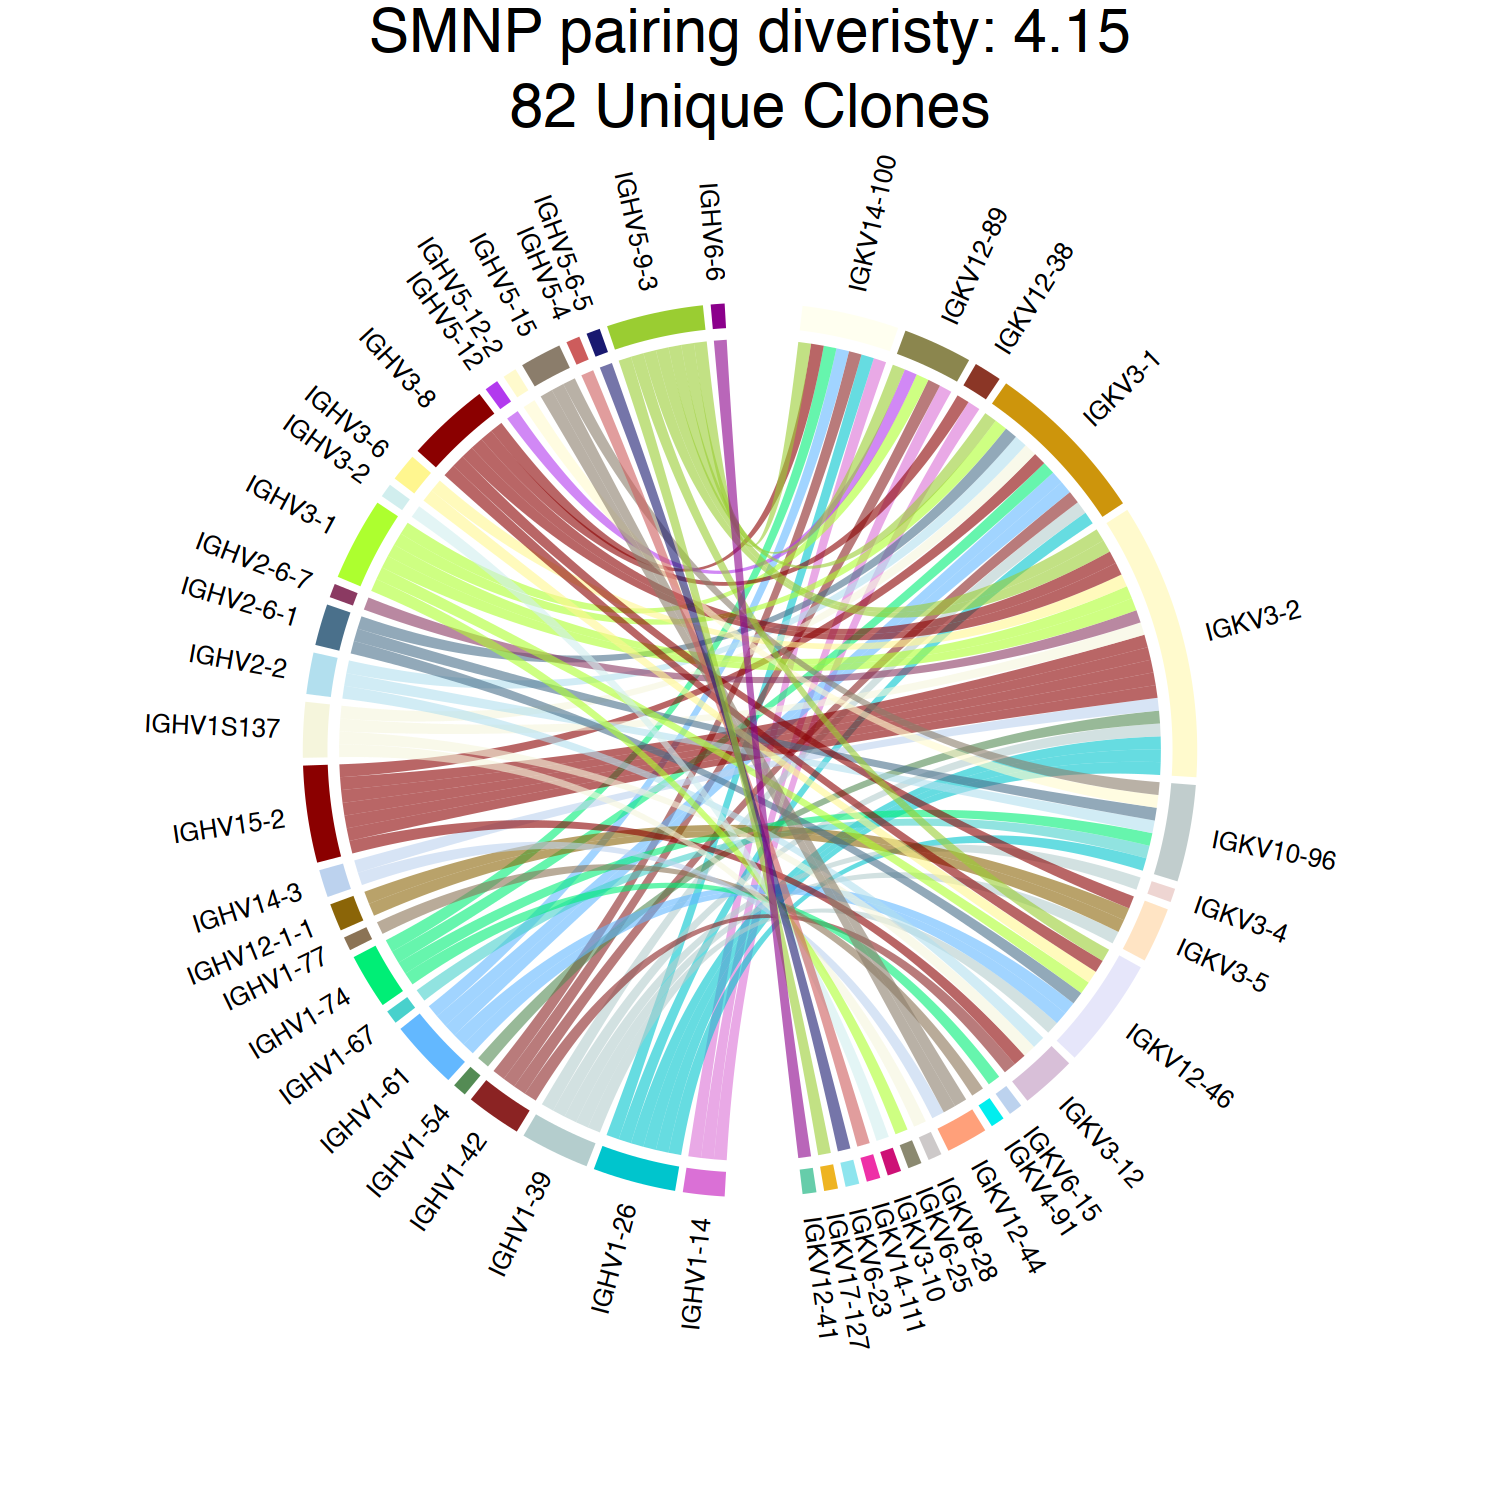

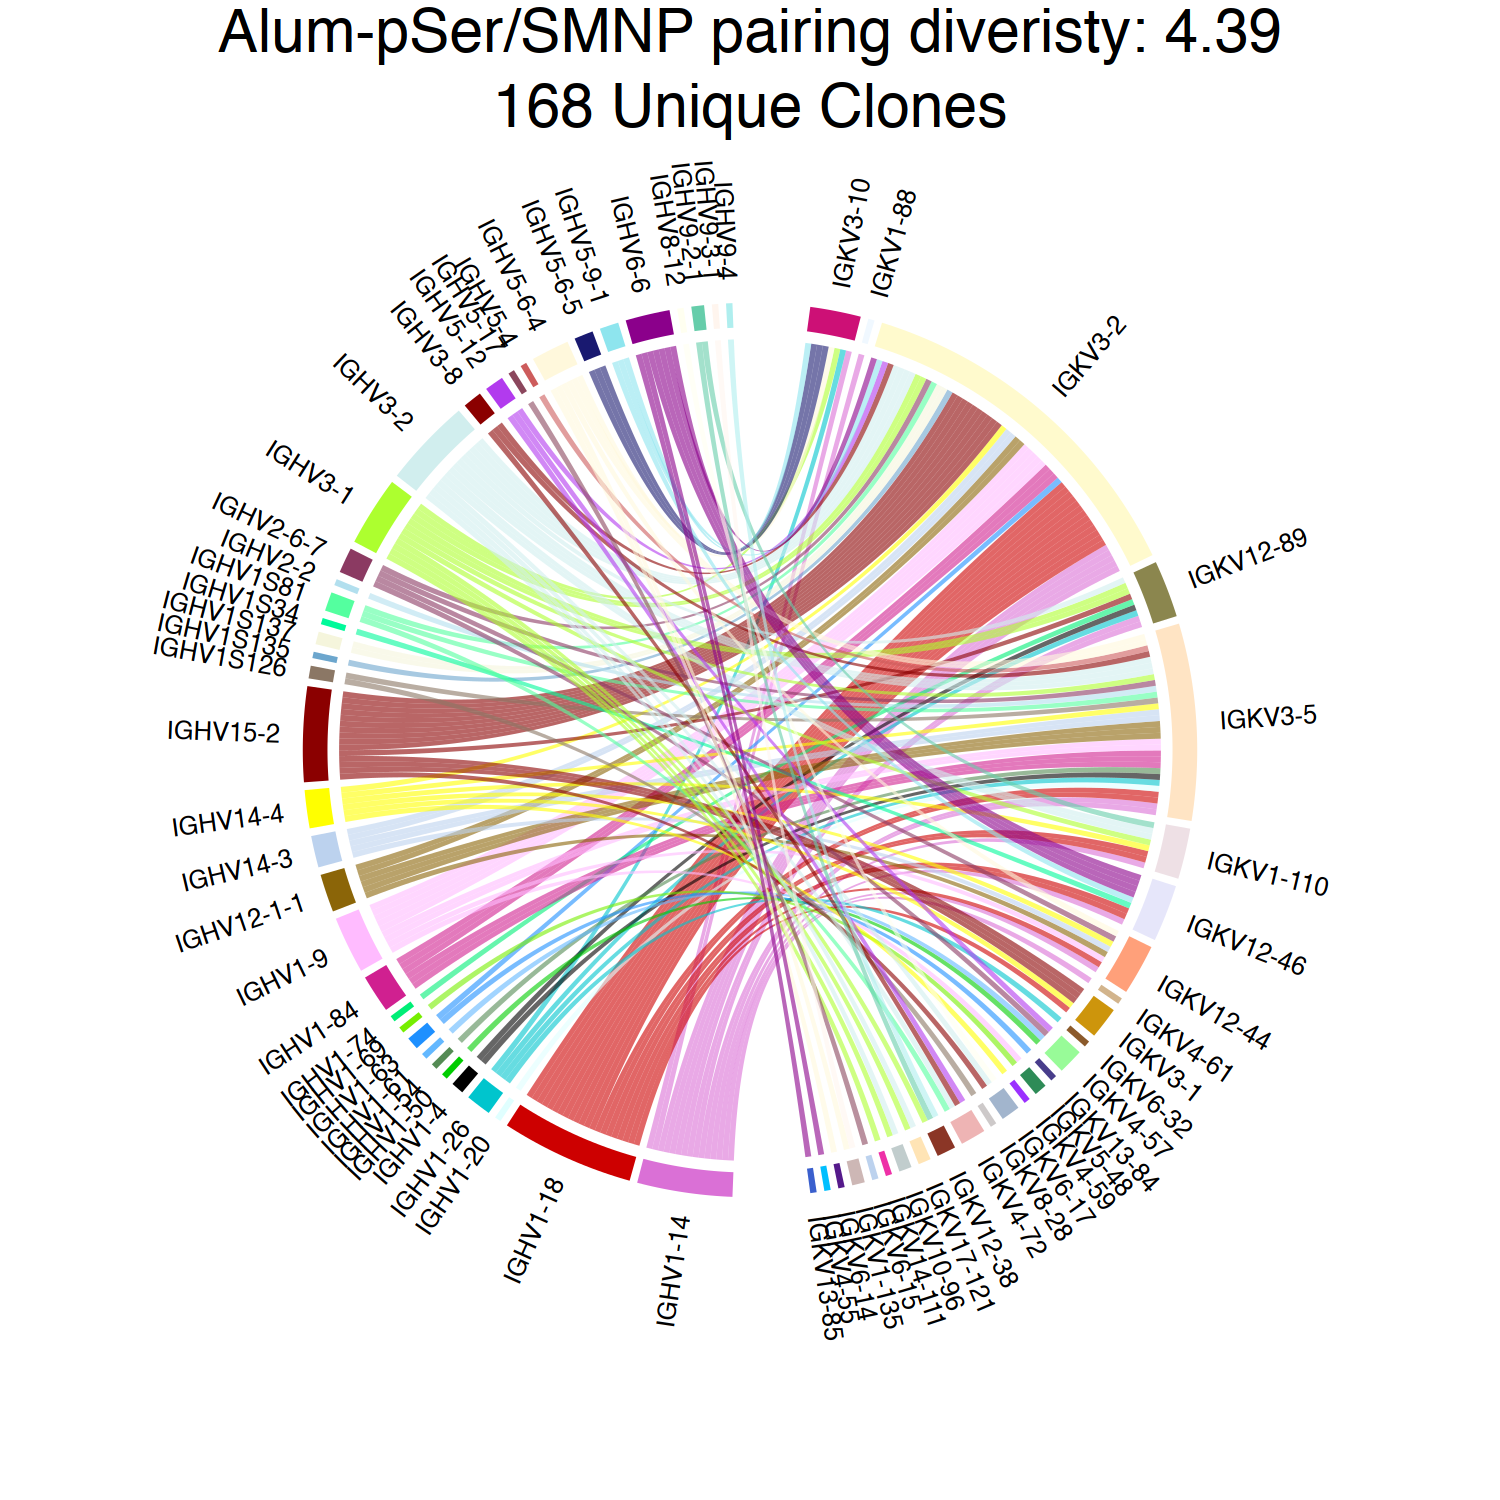

In [145]:
options(repr.plot.height=5, repr.plot.width=5,repr.plot.res=300)
jz.chordDiagram(df4circa, GROUP='Alum-pSer',by.clone = TRUE,expanded=TRUE,
                font.size = 0.5,title.size=0.4)
jz.chordDiagram(df4circa, GROUP='SMNP',by.clone = TRUE,expanded=TRUE,
                font.size = 0.5,title.size=0.4)
jz.chordDiagram(df4circa, GROUP='Alum-pSer/SMNP',by.clone = TRUE,expanded=TRUE,
                font.size = 0.5,title.size=0.4)

In [70]:
filename='figures/fig3/chord_diagram_pSer.pdf'
pdf(filename, width=3, height=3,useDingbats=FALSE,compress=FALSE)

options(repr.plot.height=3, repr.plot.width=3,repr.plot.res=300)
jz.chordDiagram(df4circa, GROUP='Alum-pSer',by.clone = TRUE,expanded=TRUE,
                font.size = 0.5,title.size=0.4)

dev.off()

`summarise()` has grouped output by 'group', 'CLONE', 'IGH_GERMLINE_V_CALL'.
You can override using the `.groups` argument.
`summarise()` has grouped output by 'group', 'IGH_GERMLINE_V_CALL'. You can
override using the `.groups` argument.


pdf 
  2

In [71]:
filename='figures/fig3/chord_diagram_SMNP.pdf'
pdf(filename, width=3, height=3,useDingbats=FALSE,compress=FALSE)

options(repr.plot.height=3, repr.plot.width=3,repr.plot.res=300)
jz.chordDiagram(df4circa, GROUP='SMNP',by.clone = TRUE,expanded=TRUE,
                font.size = 0.5,title.size=0.4)

dev.off()

`summarise()` has grouped output by 'group', 'CLONE', 'IGH_GERMLINE_V_CALL'.
You can override using the `.groups` argument.
`summarise()` has grouped output by 'group', 'IGH_GERMLINE_V_CALL'. You can
override using the `.groups` argument.


pdf 
  2

In [72]:
filename='figures/fig3/chord_diagram_both.pdf'
pdf(filename, width=3, height=3,useDingbats=FALSE,compress=FALSE)

options(repr.plot.height=3, repr.plot.width=3,repr.plot.res=300)
jz.chordDiagram(df4circa, GROUP='Alum-pSer/SMNP',by.clone = TRUE,expanded=TRUE,
                font.size = 0.5,title.size=0.4)

dev.off()

`summarise()` has grouped output by 'group', 'CLONE', 'IGH_GERMLINE_V_CALL'.
You can override using the `.groups` argument.
`summarise()` has grouped output by 'group', 'IGH_GERMLINE_V_CALL'. You can
override using the `.groups` argument.


pdf 
  2

`summarise()` has grouped output by 'group', 'CLONE', 'IGH_GERMLINE_V_CALL'.
You can override using the `.groups` argument.
`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


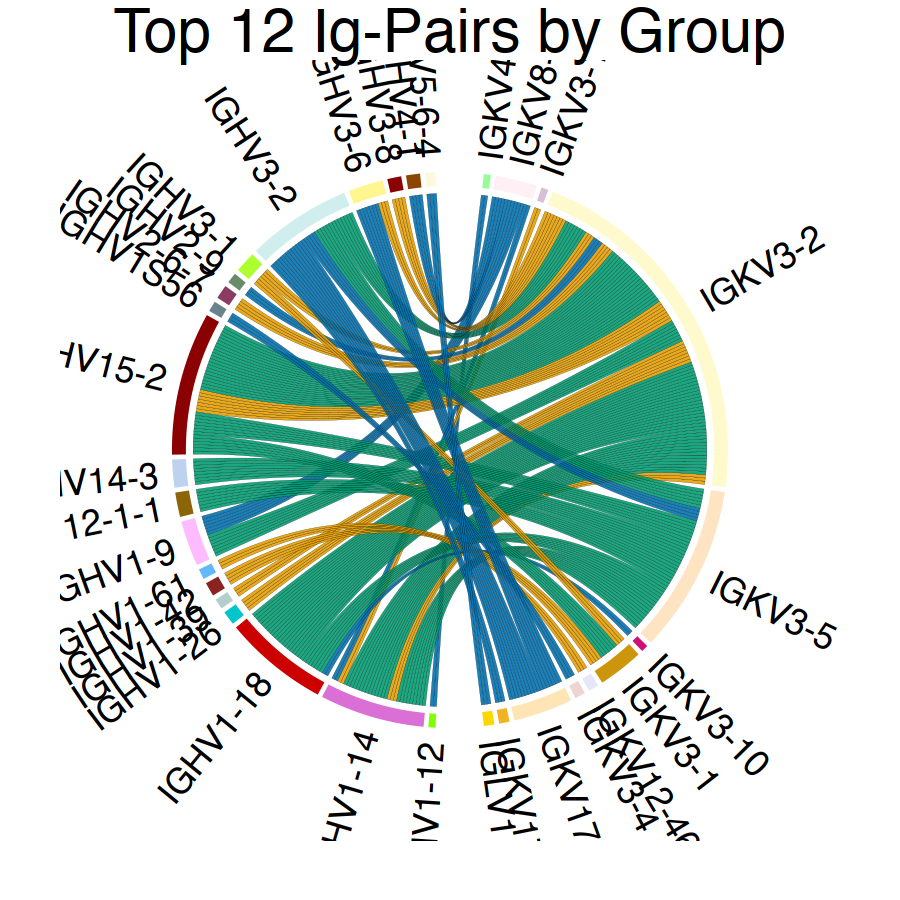

In [76]:
options(repr.plot.height=3, repr.plot.width=3,repr.plot.res=300)
a = df4circa 
# get colors 
gene.colors = c(a$IGH_COLOR, a$IGL_COLOR)
names(gene.colors) = c(a$IGH_GERMLINE_V_CALL, a$IGL_V_CALL)
group.colors.df = data.frame(group=c('Alum-pSer','SMNP','Alum-pSer/SMNP'), col = c('#0072B2','#E69F00','#009E73'))

# collapse clones 
# if a clone has more than one paired light chain, keep the light chain with greater 
# number of cells in the clone
a = a %>% group_by(group,CLONE,IGH_GERMLINE_V_CALL,IGL_V_CALL)%>% 
    summarize(nigl.clone = n()) %>% mutate(ncell.clone=sum(nigl.clone)) %>%
    arrange(desc(nigl.clone)) %>% dplyr::slice(1) %>% ungroup() %>% 
    mutate(pair=paste(IGH_GERMLINE_V_CALL,IGL_V_CALL,sep='_')) %>% 
    mutate(ident = paste(group,pair,sep='_'))

pairs2plot = a %>% group_by(group,pair) %>% summarise(count=n()) %>% arrange(desc(count)) %>% 
slice(1:12) %>% mutate(ident = paste(group,pair,sep='_'))
a = a %>% filter(ident %in% pairs2plot$ident)

circos.par(start.degree = -90) # make it left and right symmetry ,circle.margin = 0.1
a$value=1

# order by igh genes 
b = a %>% dplyr::select(c(IGH_GERMLINE_V_CALL, IGL_V_CALL, value,group)) %>% arrange(IGH_GERMLINE_V_CALL,group)

# make a color vector
link.color = b %>% dplyr::select(group) 
link.color$col = group.colors.df$col[match(link.color$group,group.colors.df$group)]

# make a outline vector 
link.outline = b %>% dplyr::select(group)
link.outline$border='black'

# draw chord diagram 
chordDiagram(b, grid.col = gene.colors, col=link.color$col, annotationTrack = c("grid"), 
             link.lwd = 0.05, link.border = link.outline$border,
             preAllocateTracks = 1,transparency = 0.1)
title(main ='Top 12 Ig-Pairs by Group',cex = 0.3)

# add label 
circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
    xlim = get.cell.meta.data("xlim")
    ylim = get.cell.meta.data("ylim")
    sector.name = get.cell.meta.data("sector.index")
    circos.text(mean(xlim), ylim[1] + .1, sector.name, facing = "clockwise", niceFacing = TRUE, 
              adj = c(0, 0.5),cex = 0.7)
#         circos.axis(h = "top", labels.cex = 0.5, major.tick.length = 0.2, sector.index = sector.name, 
#                   track.index = 2)
}, bg.border = NA)
circos.clear()

In [123]:
filename='figures/fig3/chord_diagram_top12pairs.pdf'
pdf(filename, width=6, height=6,useDingbats=FALSE,compress=FALSE)

a = df4circa 
# get colors 
gene.colors = c(a$IGH_COLOR, a$IGL_COLOR)
names(gene.colors) = c(a$IGH_GERMLINE_V_CALL, a$IGL_V_CALL)
group.colors.df = data.frame(group=c('Alum-pSer','SMNP','Alum-pSer/SMNP'), col = c('#0072B2','#E69F00','#009E73'))

# collapse clones 
# if a clone has more than one paired light chain, keep the light chain with greater 
# number of cells in the clone
a = a %>% group_by(group,CLONE,IGH_GERMLINE_V_CALL,IGL_V_CALL)%>% 
    summarize(nigl.clone = n()) %>% mutate(ncell.clone=sum(nigl.clone)) %>%
    arrange(desc(nigl.clone)) %>% dplyr::slice(1) %>% ungroup() %>% 
    mutate(pair=paste(IGH_GERMLINE_V_CALL,IGL_V_CALL,sep='_')) %>% 
    mutate(ident = paste(group,pair,sep='_'))

pairs2plot = a %>% group_by(group,pair) %>% summarise(count=n()) %>% arrange(desc(count)) %>% 
slice(1:12) %>% mutate(ident = paste(group,pair,sep='_'))
a = a %>% filter(ident %in% pairs2plot$ident)

circos.par(start.degree = -90) # make it left and right symmetry ,circle.margin = 0.1
a$value=1

# order by igh genes 
b = a %>% dplyr::select(c(IGH_GERMLINE_V_CALL, IGL_V_CALL, value,group)) %>% arrange(IGH_GERMLINE_V_CALL,group)

# make a color vector
link.color = b %>% dplyr::select(group) 
link.color$col = group.colors.df$col[match(link.color$group,group.colors.df$group)]

# make a outline vector 
link.outline = b %>% dplyr::select(group)
link.outline$border='black'

# draw chord diagram 
chordDiagram(b, grid.col = gene.colors, col=link.color$col, annotationTrack = c("grid"), 
             link.lwd = 0.05, link.border = link.outline$border,
             preAllocateTracks = 1,transparency = 0)
title(main ='Top 12 Ig-Pairs by Group',cex = 0.3)

# add label 
circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
    xlim = get.cell.meta.data("xlim")
    ylim = get.cell.meta.data("ylim")
    sector.name = get.cell.meta.data("sector.index")
    circos.text(mean(xlim), ylim[1] + .1, sector.name, facing = "clockwise", niceFacing = TRUE, 
              adj = c(0, 0.5),cex = 0.7)
#         circos.axis(h = "top", labels.cex = 0.5, major.tick.length = 0.2, sector.index = sector.name, 
#                   track.index = 2)
}, bg.border = NA)
circos.clear()

dev.off()


`summarise()` has grouped output by 'group', 'CLONE', 'IGH_GERMLINE_V_CALL'.
You can override using the `.groups` argument.
`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


pdf 
  2

In [85]:
table(srat@meta.data$group[srat$CLONE>0])


     Alum-pSer           SMNP Alum-pSer/SMNP 
           662            852           3107 

In [89]:
table(srat@meta.data$group[srat$recovery==3])


     Alum-pSer           SMNP Alum-pSer/SMNP 
           426            583           1941 

In [7]:
library(foreach)
library(doParallel)


Loading required package: iterators

Loading required package: parallel



In [74]:
# boostrap clonal eveness 
jz.bootstrap = function(metadata) {
    df = metadata %>% group_by(group) %>% 
        sample_n(662,replace = FALSE) %>% ungroup()
    
    # calculate clonal eveness 
    df4gg = df %>% group_by(group, mouse.id, CLONE) %>% 
    summarize(ncell.clone.mouse = n()) %>% 
    mutate(ncell.mouse = sum(ncell.clone.mouse)) %>% 
    filter(ncell.mouse>=5) %>% # remove mouse with less than 5 bcrs
    summarize(div = vegan::diversity(ncell.clone.mouse, base=n()),ncell.mouse = sum(ncell.clone.mouse)) 

    results = kruskal.test(div ~ group, data = df4gg)
    return(results$p.val)
}

# Set the number of cores to be used in parallel
num_cores <- detectCores() 

# set number of ite
bootstrap_iterations <- 10000

# Register parallel backend
cl <- makeCluster(num_cores)
registerDoParallel(cl)

metadata = srat@meta.data %>% filter(CLONE>0) #%>% rename('Mouse' = 'mouse.id','Group'='group')

vec1 <- foreach(i = 1:bootstrap_iterations, .combine = c) %dopar% {
    library(dplyr)
    #library(stringr)
    suppressMessages(jz.bootstrap(metadata))
}

# stop parallel backend 
stopCluster(cl)

In [75]:
quantile(vec1,0.05)
quantile(vec1,0.95)

5% 
0.004011719

95% 
0.05039391

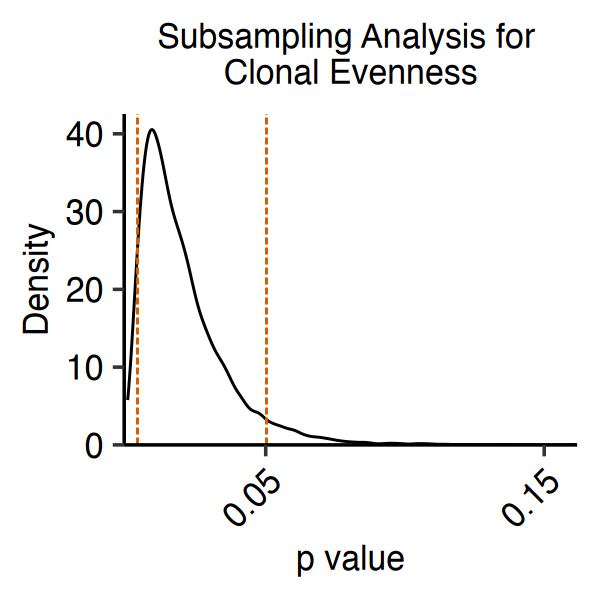

In [88]:
options(repr.plot.width=2, repr.plot.height=2, repr.plot.res=300)
df4gg = data.frame(p.val = vec1)
df4gg %>% 
ggplot(aes(x=p.val)) + theme_classic()+
geom_histogram(aes(y=..density..),bins=100,position='dodge', 
               fill='white', linewidth=0.1)+
geom_density(alpha=0.5, linewidth=0.25) +
geom_vline(aes(xintercept = quantile(vec1,0.05)),linetype='longdash',color="#D55E00",linewidth=0.25)+
geom_vline(aes(xintercept = quantile(vec1,0.95)),linetype='longdash',color="#D55E00",linewidth=0.25)+
labs(y='Density',x='p value', title='Subsampling Analysis for \nClonal Evenness')+
scale_x_continuous(expand=c(0,0),breaks=c(0.05,0.15,0.3,0.5,0.7,0.9,1.0))+
scale_y_continuous(expand=c(0,0)) +
scale_fill_manual(values=c("#9dbb5a", "#982b39"))+
scale_color_manual(values=c("#9dbb5a", "#982b39"))+
Axis_themes 

In [78]:
# boostrap number of recovered clones
jz.bootstrap = function(metadata) {
    df = metadata %>% group_by(group) %>% 
        sample_n(662,replace = FALSE) %>% ungroup()
    
    # calculate clonal eveness 
    df4gg = df %>% filter(CLONE>0) %>% 
    group_by(group, mouse.id, CLONE) %>% summarize(ncell.clone = n()) %>% 
    summarize(richness = n(),nbcr.mouse = sum(ncell.clone)) %>%
    filter(nbcr.mouse>=4) # remove mouse with less than 5 bcrs

    results = kruskal.test(richness ~ group, data = df4gg)
    return(results$p.val)
}

# Set the number of cores to be used in parallel
num_cores <- detectCores() 

# set number of ite
bootstrap_iterations <- 10000

# Register parallel backend
cl <- makeCluster(num_cores)
registerDoParallel(cl)

metadata = srat@meta.data %>% filter(CLONE>0) #%>% rename('Mouse' = 'mouse.id','Group'='group')

vec2 <- foreach(i = 1:bootstrap_iterations, .combine = c) %dopar% {
    library(dplyr)
    #library(stringr)
    suppressMessages(jz.bootstrap(metadata))
}

# stop parallel backend 
stopCluster(cl)

In [79]:
quantile(vec2,0.05)
quantile(vec2,0.95)

5% 
0.02002605

95% 
0.04067016

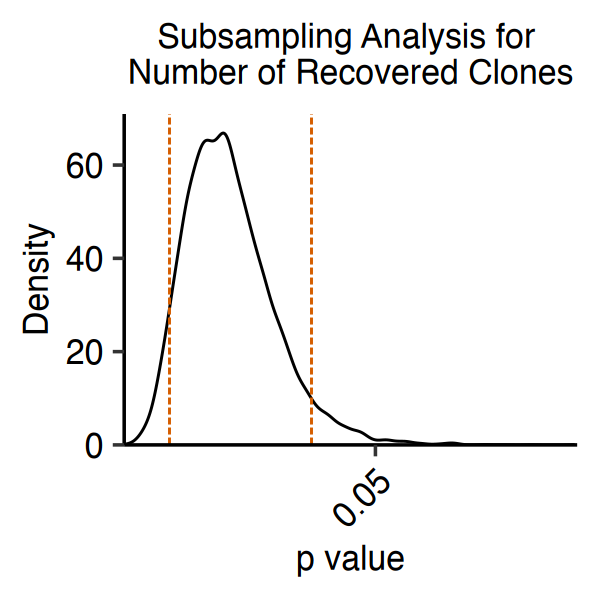

In [86]:
options(repr.plot.width=2, repr.plot.height=2, repr.plot.res=300)
df4gg = data.frame(p.val = vec2)
df4gg %>% 
ggplot(aes(x=p.val)) + theme_classic()+
geom_histogram(aes(y=..density..),bins=100,position='dodge', 
               fill='white', linewidth=0.1)+
geom_density(alpha=0.5, linewidth=0.25) +
geom_vline(aes(xintercept = quantile(vec2,0.05)),linetype='longdash',color="#D55E00",linewidth=0.25)+
geom_vline(aes(xintercept = quantile(vec2,0.95)),linetype='longdash',color="#D55E00",linewidth=0.25)+
labs(y='Density',x='p value', title='Subsampling Analysis for \nNumber of Recovered Clones')+
scale_x_continuous(expand=c(0,0),breaks=c(0.05,0.15,0.3,0.5,0.7,0.9,1.0))+
scale_y_continuous(expand=c(0,0)) +
scale_fill_manual(values=c("#9dbb5a", "#982b39"))+
scale_color_manual(values=c("#9dbb5a", "#982b39"))+
Axis_themes 

In [ ]:
df1 = data.frame(p.val = vec1, assay = 'Clonal Evenness')
df2 = data.frame(p.val = vec2, assay = 'Number of Recovered Clones')
df4gg = rbind(df1, df2)
df4gg %>% 
ggplot(aes(x=p.val)) + theme_classic()+
geom_histogram(aes(y=..density..),bins=100,position='dodge', 
               fill='white', linewidth=0.1)+
geom_density(alpha=0.5, linewidth=0.25) +
# geom_vline(aes(xintercept = 0.1/2), linetype='dashed',color="#D55E00",linewidth=0.1)+
labs(y='Density',x='p value')+
scale_x_continuous(expand=c(0,0),breaks=c(0.05,0.15,0.3,0.5,0.7,0.9,1.0))+
scale_y_continuous(expand=c(0,0)) +
scale_fill_manual(values=c("#9dbb5a", "#982b39"))+
scale_color_manual(values=c("#9dbb5a", "#982b39"))+
Axis_themes 

In [ ]:
# boostrap pairing diversity 

In [40]:
# do cell level boostraping 
jz.bootstrap = function(metadata) {
    df = metadata %>% filter(Group!='Alum-pSer') %>% group_by(Group) %>% 
        sample_n(200,replace = FALSE) %>% ungroup()
    # keep the first light chain v gene when ambiguious 
    df = df %>% mutate(IGL_V_CALL = str_split_i(IGL_V_CALL,',',1))
    # remove allele info 
    df = df %>% dplyr::select(Group,  Mouse, CLONE, IGH_GERMLINE_V_CALL,IGL_V_CALL)
    df = df %>% mutate(IGH_GERMLINE_V_CALL = str_split_i(IGH_GERMLINE_V_CALL,'\\*',1),
                       IGL_V_CALL = str_split_i(IGL_V_CALL,'\\*',1))
    # if a clone has more than one paired light chain, keep the light chain with greater number of cells in the clone 
    df = df %>% group_by(Group,Mouse,CLONE,IGH_GERMLINE_V_CALL,IGL_V_CALL) %>% 
        summarize(nigl.clone = n()) %>% mutate(ncell.clone=sum(nigl.clone)) %>%
        arrange(desc(nigl.clone)) %>% dplyr::slice(1) %>% ungroup()
    
    # calculate the pairing diversity 
    df4gg = df %>% #group_by(Group) %>% sample_n(100,replace = FALSE) %>% ungroup() %>% 
        group_by(Group, Mouse, IGH_GERMLINE_V_CALL,IGL_V_CALL) %>% 
        summarize(npairing=n()) %>% ungroup() %>% group_by(Group,Mouse) %>%
        summarize(div=vegan::diversity(npairing)) #%>% filter(div>0)
    x=df4gg[df4gg$Group=='SMNP','div'] 
    y=df4gg[df4gg$Group=='Alum-pSer/SMNP','div']
    results = t.test(x$div, y$div, alternative = "two.sided")
    return(results$p.val)
}

# Set the number of cores to be used in parallel
num_cores <- detectCores() 

# set number of ite
bootstrap_iterations <- 10000

# Register parallel backend
cl <- makeCluster(num_cores)
registerDoParallel(cl)

metadata = srat@meta.data %>% filter(recovery==3) %>% rename('Mouse' = 'mouse.id','Group'='group')

vec1 <- foreach(i = 1:bootstrap_iterations, .combine = c) %dopar% {
    library(dplyr)
    library(stringr)
    suppressMessages(jz.bootstrap(metadata))
}

# stop parallel backend 
stopCluster(cl)

In [41]:
# do clone level boostraping 
jz.bootstrap = function(df) {
    # calculate the pairing diversity 
    N.subsample = 100 #sum(as.numeric(df$Group=='SMNP'))
    df4gg = df %>% group_by(Group) %>% sample_n(N.subsample,replace = FALSE) %>% ungroup() %>% 
        group_by(Group, Mouse, IGH_GERMLINE_V_CALL,IGL_V_CALL) %>% 
        summarize(npairing=n()) %>% ungroup() %>% group_by(Group,Mouse) %>%
        summarize(div=vegan::diversity(npairing)) #%>% filter(div>0)
    x=df4gg[df4gg$Group=='SMNP','div'] 
    y=df4gg[df4gg$Group=='Alum-pSer/SMNP','div']
    results = t.test(x$div, y$div, alternative = "two.sided")
    
    return(results$p.val)
}

# Set the number of cores to be used in parallel
num_cores <- detectCores() 

# set number of ite
bootstrap_iterations <- 10000

# Register parallel backend
cl <- makeCluster(num_cores)
registerDoParallel(cl)

metadata = srat@meta.data %>% filter(recovery==3) %>% rename('Mouse' = 'mouse.id','Group'='group')

# keep the first light chain v gene when ambiguious 
df = metadata %>% mutate(IGL_V_CALL = str_split_i(IGL_V_CALL,',',1))
# remove allele info 
df = df %>% dplyr::select(Group,  Mouse, CLONE, IGH_GERMLINE_V_CALL,IGL_V_CALL)
df = df %>% mutate(IGH_GERMLINE_V_CALL = str_split_i(IGH_GERMLINE_V_CALL,'\\*',1),
                   IGL_V_CALL = str_split_i(IGL_V_CALL,'\\*',1))
# if a clone has more than one paired light chain, keep the light chain with greater number of cells in the clone 
df = df %>% group_by(Group,Mouse,CLONE,IGH_GERMLINE_V_CALL,IGL_V_CALL) %>% 
    summarize(nigl.clone = n()) %>% mutate(ncell.clone=sum(nigl.clone)) %>%
    arrange(desc(nigl.clone)) %>% dplyr::slice(1) %>% ungroup()
# remove pser 
df = df%>% filter(Group!='Alum-pSer') 

vec2 <- foreach(i = 1:bootstrap_iterations, .combine = c) %dopar% {
    library(dplyr)
    suppressMessages(jz.bootstrap(df))
}

# stop parallel backend 
stopCluster(cl)

`summarise()` has grouped output by 'Group', 'Mouse', 'CLONE',
'IGH_GERMLINE_V_CALL'. You can override using the `.groups` argument.


In [48]:
quantile(vec1, 0.05) 
quantile(vec1, 0.95) 

5% 
0.06246436

95% 
0.9318985

In [49]:
quantile(vec2, 0.05) 
quantile(vec2, 0.95) 

5% 
0.05807867

95% 
0.8981722

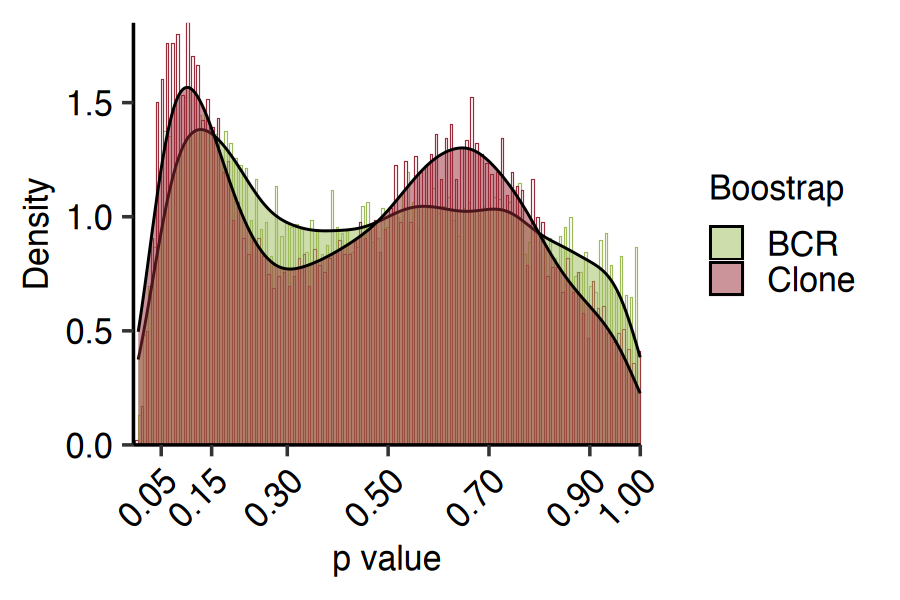

In [99]:
df1 = data.frame(p.val = vec1, Boostrap='BCR')
df2 = data.frame(p.val = vec2, Boostrap='Clone')
df4gg=rbind(df1,df2)

options(repr.plot.width=3, repr.plot.height=2)

df4gg %>% 
ggplot(aes(x=p.val)) + theme_classic()+
geom_histogram(aes(y=..density.., color=Boostrap),bins=100,position='dodge', 
               fill='white', linewidth=0.1)+
geom_density(aes(fill=Boostrap), alpha=0.5, linewidth=0.25) +
# geom_vline(aes(xintercept = 0.1/2), linetype='dashed',color="#D55E00",linewidth=0.1)+
labs(y='Density',x='p value')+
scale_x_continuous(expand=c(0,0),breaks=c(0.05,0.15,0.3,0.5,0.7,0.9,1.0))+
scale_y_continuous(expand=c(0,0)) +
scale_fill_manual(values=c("#9dbb5a", "#982b39"))+
scale_color_manual(values=c("#9dbb5a", "#982b39"))+
Axis_themes 

out = 'figures/fig3/boostrap_pairing_diversity.pdf'
ggsave(out,device='pdf', height = 2, width = 3,
       dpi = 300,useDingbats = FALSE)


In [ ]:
# Public clonal analysis 

In [50]:
library(ggraph)
library(igraph)


Attaching package: ‘ggraph’


The following object is masked from ‘package:sp’:

    geometry


Warning message:
“package ‘igraph’ was built under R version 4.3.3”

Attaching package: ‘igraph’


The following object is masked from ‘package:Seurat’:

    components


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [51]:
hc = read.table('bcr_output/05_hc_private_clones_germ-pass.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t') 
dim(hc)

hc.meta = read.table('bcr_output/05_hc_meta_clones_germ-pass.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t') 
dim(hc.meta)

lc = read.table('bcr_output/03_lc_translated.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t') 
dim(lc)

[1] 4637   95

[1] 4637   95

[1] 8715   86

In [52]:
metadata = srat@meta.data

hc.match = hc %>% filter(hc$LANE_ID %in% metadata$cell_id) %>% 
mutate(IGH_GERMLINE_V_CALL = str_split_i(GERMLINE_V_CALL,',',1))
dim(hc)

hc.meta.match = hc.meta %>% filter(hc.meta$LANE_ID %in% metadata$cell_id) %>% 
mutate(IGH_GERMLINE_V_CALL = str_split_i(GERMLINE_V_CALL,',',1))

lc.match = lc %>% filter(lc$LANE_ID %in% metadata$cell_id) %>% 
mutate(IGL_V_CALL = str_split_i(V_CALL,',',1))
dim(lc)

metadata$IGH_recovery = as.numeric(metadata$cell_id %in% hc$LANE_ID) * 2
metadata$IGL_recovery = as.numeric(metadata$cell_id %in% lc$LANE_ID)
metadata$recovery = metadata$IGH_recovery + metadata$IGL_recovery

# recovery info
srat$recovery = metadata$recovery[match(srat$cell_id, metadata$cell_id)]

# heavy chain info
srat$IGH_GERMLINE_V_CALL = hc.match$IGH_GERMLINE_V_CALL[match(srat$cell_id, hc.match$LANE_ID)]
srat$CLONE = hc.match$CLONE[match(srat$cell_id, hc.match$LANE_ID)]
srat$META_CLONE = hc.meta.match$CLONE[match(srat$cell_id, hc.meta.match$LANE_ID)]

# light chain info
srat$IGL_V_CALL = lc.match$IGL_V_CALL[match(srat$cell_id, lc.match$LANE_ID)]


[1] 4637   95

[1] 8715   86

In [53]:
# check if public clone includes all private clones 
metadata = srat@meta.data %>% filter(CLONE>0)
test = metadata %>% count(CLONE, META_CLONE) 
duplicated(test$CLONE) %>% sum()
#test
test[duplicated(test$CLONE),] %>% head()

[1] 324

CLONE META_CLONE n
21 20     70        1
22 20     71        1
26 23    161        1
28 24    198        2
33 28    139        1
38 32    139        2

In [54]:
# combine metaclones whose private clones are the same 
metadata = srat@meta.data %>% filter(CLONE>0)

test = metadata %>% group_by(group, mouse.id, CLONE, META_CLONE) %>% 
summarise(ncell.meta.clone=n()) %>% mutate(nmeta.clone=sum(ncell.meta.clone)) %>%
# find such private clones
group_by(group, mouse.id, CLONE) %>% mutate(nmeta.clone = n()) %>% filter(nmeta.clone >1) %>% 
# combine their metaclones 
mutate(META_CLONE = first(META_CLONE)) %>% ungroup()

metadata = metadata%>% 
left_join(test[,c('CLONE', 'META_CLONE')] %>% distinct(),by = "CLONE",suffix = c("", "_new")) %>%
mutate(META_CLONE = ifelse(!is.na(META_CLONE_new), META_CLONE_new, META_CLONE)) %>%
select(-META_CLONE_new)


`summarise()` has grouped output by 'group', 'mouse.id', 'CLONE'. You can
override using the `.groups` argument.


In [55]:
# check if public clone includes all private clones 
test = metadata %>% count(CLONE, META_CLONE) 
duplicated(test$CLONE) %>% sum()
test[duplicated(test$CLONE),]

[1] 0

CLONE META_CLONE n

In [56]:
# check if different private clones from the same mouse are in one public clone 
metadata = srat@meta.data %>% filter(CLONE>0)
test = metadata %>% count(mouse.id, META_CLONE, CLONE) %>% 
count(META_CLONE,mouse.id) %>% filter(n>1)

duplicated(test$META_CLONE) %>% sum()
#test
#test[duplicated(test$META_CLONE),]

[1] 0

In [57]:
metadata = srat@meta.data %>% filter(META_CLONE>0) %>% rename('Mouse' = 'mouse.id','Group'='group')

# combine metaclones whose private clones are the same 
test = metadata %>% group_by(Group, Mouse, CLONE, META_CLONE) %>% 
summarise(ncell.meta.clone=n()) %>% mutate(nmeta.clone=sum(ncell.meta.clone)) %>%
# find such private clones
group_by(Group, Mouse, CLONE) %>% mutate(nmeta.clone = n()) %>% filter(nmeta.clone >1) %>% 
# combine their metaclones 
mutate(META_CLONE = first(META_CLONE)) %>% ungroup()
metadata = metadata%>% 
left_join(test[,c('CLONE', 'META_CLONE')] %>% distinct(),by = "CLONE",suffix = c("", "_new")) %>%
mutate(META_CLONE = ifelse(!is.na(META_CLONE_new), META_CLONE_new, META_CLONE)) %>%
select(-META_CLONE_new)

# label private and meta clone 
metadata$private = paste0('P',metadata$CLONE)
metadata$meta = paste0('M',metadata$META_CLONE)

# collapse private and meta clone 
temp.df = metadata %>% group_by(meta,Group,private) %>% summarize(ncell.clone=n()) %>% 
mutate(from = meta, to = paste(meta,private,sep='.')) %>% ungroup()

# Create first hiarchy 
df1 = temp.df %>% select(from, to)
metaclones = temp.df %>% group_by(meta) %>% summarise(nclone=n()) %>% filter(nclone>1)
v1 = temp.df %>% group_by(meta) %>% 
summarize(ncell.meta = sum(ncell.clone), nclone.meta = n()) %>% 
rename('name'='meta','count'='ncell.meta', 'nclone' = 'nclone.meta') %>% 
mutate(Group=ifelse(name %in% metaclones$meta,'_Metaclone','_Metaclone1'),size=0) 


`summarise()` has grouped output by 'Group', 'Mouse', 'CLONE'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'meta', 'Group'. You can override using the
`.groups` argument.


In [58]:
# second hiarchy 
#temp.df$ncell.clone[temp.df$ncell.clone>100] = 100
temp.df2 = temp.df[rep(seq_len(nrow(temp.df)), temp.df$ncell.clone), ]
temp.df2 = temp.df2 %>% mutate(from = paste(meta, private, sep='.'),to = paste(from,ncell.clone, sep='.')) %>% ungroup() 
v2 = temp.df2 %>% group_by(meta) %>% mutate(nclone = n()) %>% ungroup() %>%
select(from,ncell.clone,nclone,Group) %>% unique() %>% 
rename('name'='from','count'='ncell.clone')
v2$size = v2$count
v2 = v2 %>% mutate(meta = str_split_i(name,'\\.',1)) %>% 
mutate(Group=ifelse(meta %in% metaclones$meta,as.character(Group),paste0(Group,'1'))) %>% select(-meta)

# combine 
edges = rbind(df1)

vertices = rbind(v1,v2)
vertices$size.trans = sqrt(vertices$size)

In [60]:
unique(vertices$Group)

[1] "_Metaclone1"     "_Metaclone"      "Alum-pSer1"      "Alum-pSer"      
[5] "Alum-pSer/SMNP"  "SMNP1"           "Alum-pSer/SMNP1" "SMNP"

[1] 36726


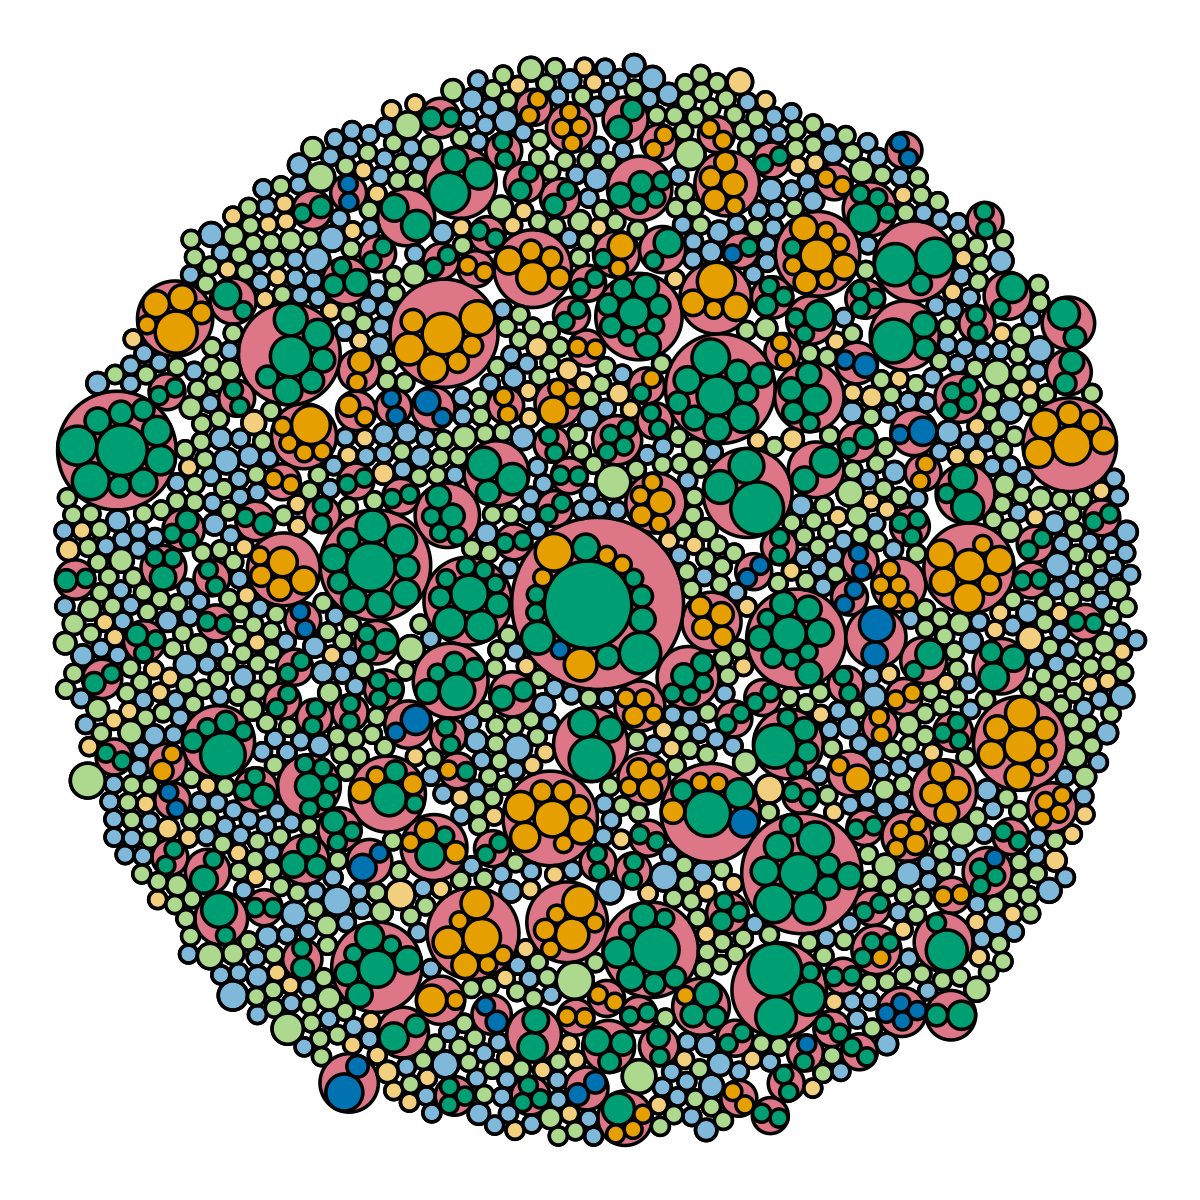

In [61]:
# Make the scale 
options(repr.plot.height=4, repr.plot.width=4,repr.plot.res=300)

n=sample(1:50000,size = 1,replace = FALSE)
print(n)
#set.seed(n)
# set.seed(476) 
set.seed(28527)

mygraph <- graph_from_data_frame(edges, vertices= vertices %>% arrange(sample(row_number())) )

col = c('Alum-pSer'='#0072B2','SMNP'='#E69F00','Alum-pSer/SMNP'='#009E73',
        'Alum-pSer1'=alpha('#0072B2',0.5),'SMNP1'=alpha('#E69F00',0.5),'Alum-pSer/SMNP1'='#acd98d',
        '_Metaclone'= alpha('#dd7788',1),
        '_Metaclone1'=NA) # #ffd94a

# Make the plot
ggraph(mygraph, layout = 'circlepack',weight = size.trans, sort.by = count) +  
geom_node_circle(aes(fill=factor(Group, levels=c('_Metaclone1','_Metaclone','Alum-pSer1','Alum-pSer','Alum-pSer/SMNP','SMNP1','Alum-pSer/SMNP1','SMNP'))),linewidth=0.3) +
theme_void() + guides(fill='none') +
scale_fill_manual(values = col, na.value = NA) 

# out = 'figures/fig3/metaclone_circlepack.pdf'
# ggsave(out,device='pdf', height = 4, width = 4,
#        dpi = 300,useDingbats = FALSE)


`summarise()` has grouped output by 'Group', 'Mouse', 'CLONE'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'META_CLONE', 'Group', 'Mouse'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'META_CLONE', 'Group'. You can override
using the `.groups` argument.


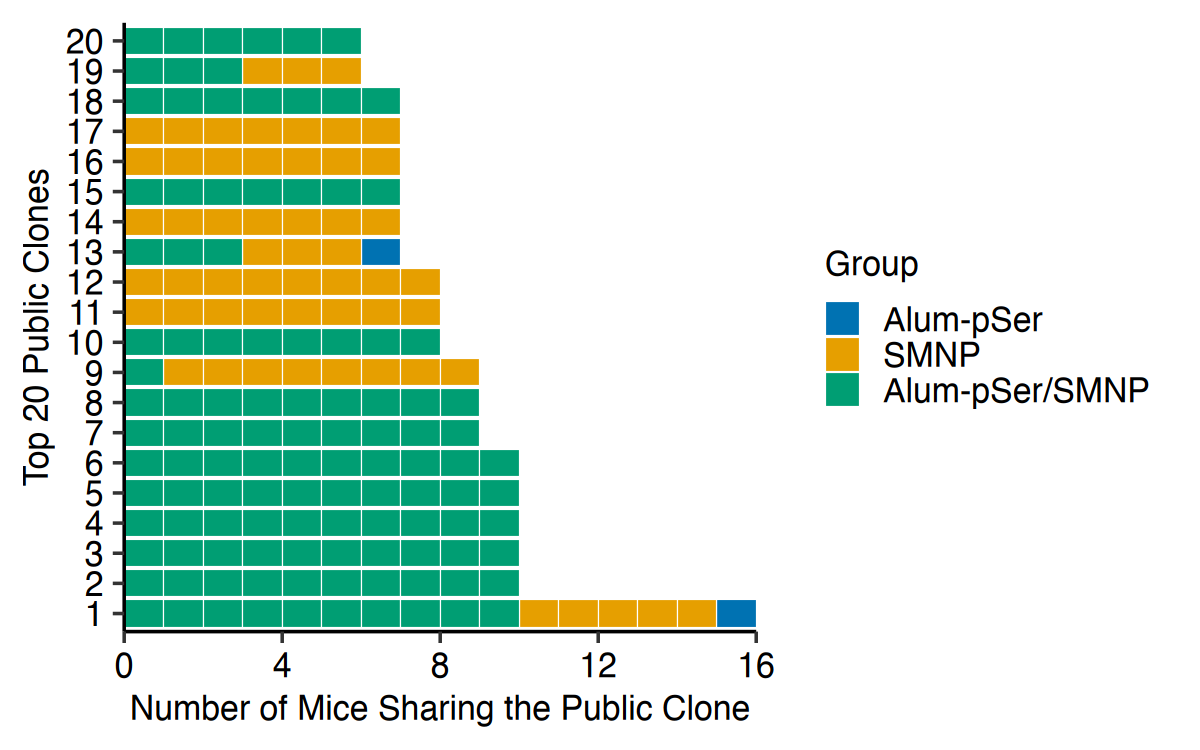

In [132]:
options(repr.plot.height=2.5, repr.plot.width=4, repr.plot.res=300)

metadata = srat@meta.data %>% filter(CLONE>0) %>% rename('Mouse' = 'mouse.id','Group'='group')
# combine metaclones whose private clones are the same 
test = metadata %>% group_by(Group, Mouse, CLONE, META_CLONE) %>% 
summarise(ncell.meta.clone=n()) %>% mutate(nmeta.clone=sum(ncell.meta.clone)) %>%
# find such private clones
group_by(Group, Mouse, CLONE) %>% mutate(nmeta.clone = n()) %>% filter(nmeta.clone >1) %>% 
# combine their metaclones 
mutate(META_CLONE = first(META_CLONE)) %>% ungroup()
metadata = metadata%>% 
left_join(test[,c('CLONE', 'META_CLONE')] %>% distinct(),by = "CLONE",suffix = c("", "_new")) %>%
mutate(META_CLONE = ifelse(!is.na(META_CLONE_new), META_CLONE_new, META_CLONE)) %>%
select(-META_CLONE_new)

# aggregate number of clones per mouse 
df1 = metadata %>% group_by(META_CLONE,Group,Mouse,CLONE) %>% summarise(ncell.clone=n()) %>% 
summarise(nclone.mouse=n(),ncell.mouse=sum(ncell.clone)) %>% ungroup() %>% arrange(desc(nclone.mouse))

# aggregate number of mouse per public clone 
df2 = df1 %>% mutate(mouse.id = paste(Group,Mouse,sep='_')) %>% 
select(META_CLONE,mouse.id) %>% unique() %>% 
count(META_CLONE,name='nmouse.meta') %>% arrange(desc(nmouse.meta)) %>% 
mutate(rank=seq(1:n())) %>% filter(rank<21)

df4gg = df1 %>% filter(META_CLONE %in% df2$META_CLONE) %>% mutate(Mouse=paste(Group,Mouse,sep='_'))

df4gg$rank = df2$rank[match(df4gg$META_CLONE, df2$META_CLONE)]
df4gg$nmouse.meta = 1 

df4gg %>% 
ggplot(aes(x=as.factor(rank),y=nmouse.meta,fill=Group)) + theme_classic()+ 
geom_bar(position='stack',stat='identity',color='white',linewidth=0.1) +
scale_y_continuous(expand=c(0,0),breaks=c(0,4,8,12,16)) + 
scale_fill_manual(values = group.col) + 
labs(x='Top 20 Public Clones',y='Number of Mice Sharing the Public Clone') +
coord_flip()+
Axis_themes+
theme(axis.text.x=element_text(angle=0,hjust=0.5))

# out = 'figures/fig3/metaclone_horiz_barplot.pdf'
# ggsave(out,device='pdf', height = 2.5, width = 4,
#        dpi = 300,useDingbats = FALSE)

`summarise()` has grouped output by 'Group', 'Mouse', 'CLONE'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'META_CLONE', 'Group', 'Mouse'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'META_CLONE', 'Group'. You can override
using the `.groups` argument.


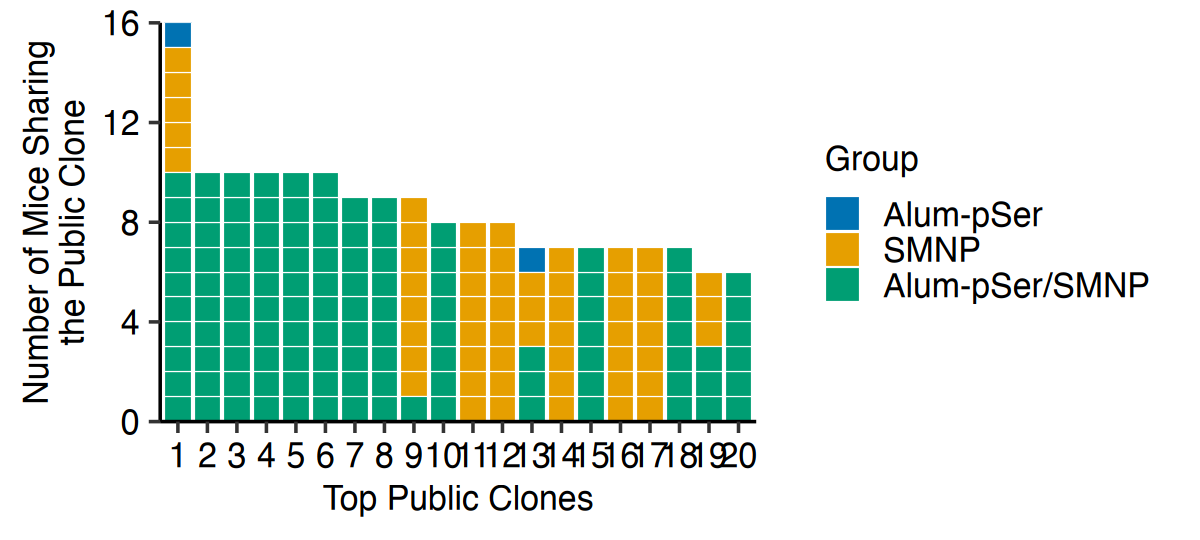

In [153]:
options(repr.plot.height=1.8, repr.plot.width=4, repr.plot.res=300)

metadata = srat@meta.data %>% filter(CLONE>0) %>% rename('Mouse' = 'mouse.id','Group'='group')
# combine metaclones whose private clones are the same 
test = metadata %>% group_by(Group, Mouse, CLONE, META_CLONE) %>% 
summarise(ncell.meta.clone=n()) %>% mutate(nmeta.clone=sum(ncell.meta.clone)) %>%
# find such private clones
group_by(Group, Mouse, CLONE) %>% mutate(nmeta.clone = n()) %>% filter(nmeta.clone >1) %>% 
# combine their metaclones 
mutate(META_CLONE = first(META_CLONE)) %>% ungroup()
metadata = metadata%>% 
left_join(test[,c('CLONE', 'META_CLONE')] %>% distinct(),by = "CLONE",suffix = c("", "_new")) %>%
mutate(META_CLONE = ifelse(!is.na(META_CLONE_new), META_CLONE_new, META_CLONE)) %>%
select(-META_CLONE_new)

# aggregate number of clones per mouse 
df1 = metadata %>% group_by(META_CLONE,Group,Mouse,CLONE) %>% summarise(ncell.clone=n()) %>% 
summarise(nclone.mouse=n(),ncell.mouse=sum(ncell.clone)) %>% ungroup() %>% arrange(desc(nclone.mouse))

# aggregate number of mouse per public clone 
df2 = df1 %>% mutate(mouse.id = paste(Group,Mouse,sep='_')) %>% 
select(META_CLONE,mouse.id) %>% unique() %>% 
count(META_CLONE,name='nmouse.meta') %>% arrange(desc(nmouse.meta)) %>% 
mutate(rank=seq(1:n())) %>% filter(rank<21)

df4gg = df1 %>% filter(META_CLONE %in% df2$META_CLONE) %>% mutate(Mouse=paste(Group,Mouse,sep='_'))

df4gg$rank = df2$rank[match(df4gg$META_CLONE, df2$META_CLONE)]
df4gg$nmouse.meta = 1 

df4gg %>% 
ggplot(aes(x=nmouse.meta, y=as.factor(rank),fill=Group)) + theme_classic()+ 
geom_bar(position='stack',stat='identity',color='white',linewidth=0.1) +
scale_x_continuous(expand=c(0,0),breaks=c(0,4,8,12,16)) + 
scale_fill_manual(values = group.col) + 
labs(x='Number of Mice Sharing\nthe Public Clone',y='Top Public Clones') +
coord_flip()+
Axis_themes+
theme(axis.text.x=element_text(angle=0,hjust=0.5))

out = 'figures/fig3/metaclone_barplot.pdf'
ggsave(out,device='pdf', height = 1.8, width = 4,
       dpi = 300,useDingbats = FALSE)

In [84]:
metadata = srat@meta.data %>% filter(META_CLONE>0) %>% rename('Mouse' = 'mouse.id','Group'='group')

# combine metaclones whose private clones are the same 
test = metadata %>% group_by(Group, Mouse, CLONE, META_CLONE) %>% 
summarise(ncell.meta.clone=n()) %>% mutate(nmeta.clone=sum(ncell.meta.clone)) %>%
# find such private clones
group_by(Group, Mouse, CLONE) %>% mutate(nmeta.clone = n()) %>% filter(nmeta.clone > 1) %>% 
# combine their metaclones 
mutate(META_CLONE = first(META_CLONE)) %>% ungroup()
metadata = metadata%>% 
left_join(test[,c('CLONE', 'META_CLONE')] %>% distinct(),by = "CLONE",suffix = c("", "_new")) %>%
mutate(META_CLONE = ifelse(!is.na(META_CLONE_new), META_CLONE_new, META_CLONE)) %>%
select(-META_CLONE_new)

# label private and meta clone 
metadata$private = paste0('P',metadata$CLONE)
metadata$meta = paste0('M',metadata$META_CLONE)

# collapse private and meta clone 
temp.df = metadata %>% group_by(meta,Group,private) %>% summarize(ncell.clone=n()) %>% 
mutate(from = meta, to = paste(meta,private,sep='.')) %>% ungroup()

# only keep public clones
df.pub = temp.df %>% filter(meta %in% metaclones$meta) 

`summarise()` has grouped output by 'Group', 'Mouse', 'CLONE'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'meta', 'Group'. You can override using the
`.groups` argument.


In [85]:
# remove public clones with less than 3 private clones
meta2keep = df.pub %>% count(meta, name='nclone') %>% filter(nclone>=2)

# find group-specific public clones 
group.specific.meta = df.pub %>% filter(meta %in% meta2keep$meta) %>% 
count(meta,Group) %>% count(meta) %>% filter(n==1)

# find number of group-specific public clones 
donut.df = df.pub %>% filter(meta %in% c(group.specific.meta$meta)) %>% 
count(meta,Group, name='nclone') %>% count(Group,name='nmeta')

# create an index system
indexed.meta = df.pub %>% mutate(index = ifelse(Group=='Alum-pSer', 3, ifelse(Group=='SMNP',4,5))) %>% 
filter(meta %in% meta2keep$meta) 

# create a column that indicates composition of the public cloneotype 
donut.df = merge(indexed.meta, indexed.meta %>% group_by(meta, index) %>% slice(1) %>% group_by(meta) %>% summarize(label = sum(index)), by='meta')

donut.df = donut.df %>% count(meta, label, name='nclone') %>% count(label,name='nmeta')

# Compute the cumulative percentages (top of each rectangle)
donut.df$ymax <- cumsum(donut.df$nmeta)
# Compute the bottom of each rectangle
donut.df$ymin <- c(0, head(donut.df$ymax, n=-1))

donut.df$textPosition <- (donut.df$ymax + donut.df$ymin) / 2
donut.df$text <- paste0(donut.df$nmeta)
donut.df

label nmeta ymax ymin textPosition text
1  3     18    18    0    9.0        18  
2  4     44    62   18   40.0        44  
3  5    126   188   62  125.0        126 
4  8      3   191  188  189.5        3   
5  9      9   200  191  195.5        9   
6 12      2   202  200  201.0        2

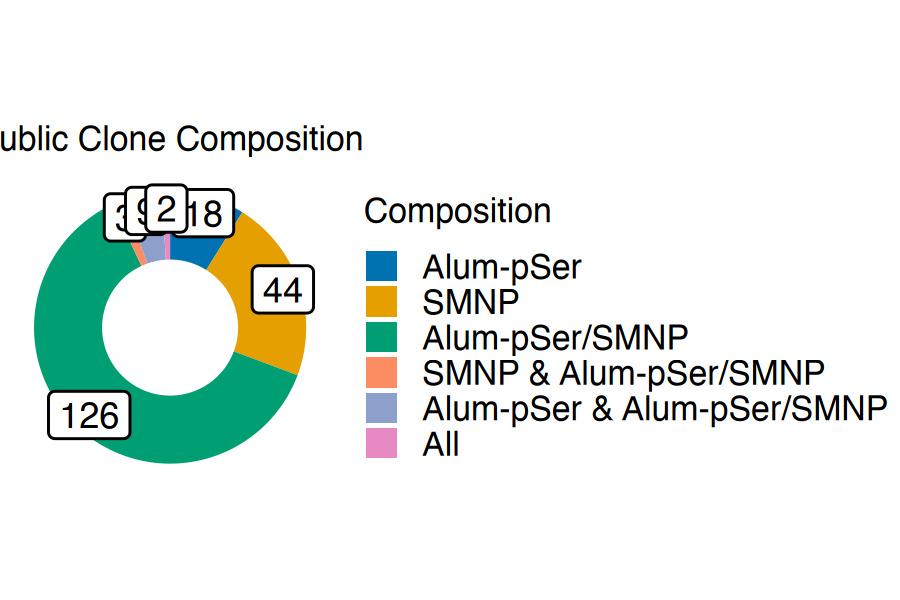

In [86]:
options(repr.plot.height=2, repr.plot.width=3,repr.plot.res=300)
donut.df %>% 
ggplot(aes())  + 
geom_rect(aes(ymax=ymax,ymin=ymin,xmax=4, xmin=2,fill=factor(label))) +
xlim(c(0, 4)) +
labs(title='Public Clone Composition',fill='Composition')+
coord_polar(theta="y") +
geom_label(x=3.5, aes(y=textPosition, label=text), size=3) +
scale_fill_manual(values = c('3'='#0072B2','4'='#E69F00','5'='#009E73',
                             '7'= brewer.pal(7, 'Set2')[7], '8'= brewer.pal(7, 'Set2')[2],
                             '9'= brewer.pal(7, 'Set2')[3],
                             '12'= brewer.pal(7, 'Set2')[4]), 
                  labels=c('3'='Alum-pSer','4'='SMNP','5'='Alum-pSer/SMNP',
                           '7'='Alum-pSer & SMNP','8'='SMNP & Alum-pSer/SMNP',
                           '9'='Alum-pSer & Alum-pSer/SMNP','12'='All')) +
theme_void() +
theme(legend.text = element_text(size =8),
     legend.title = element_text(size = 8),
     legend.key.size = unit(.3, 'cm'),
      plot.title = element_text(size = 8,hjust=0.5),
     )

out = 'figures/fig3/metaclone_donutplot.pdf'
ggsave(out,device='pdf', height = 2, width = 3,
       dpi = 300,useDingbats = FALSE)

In [83]:
# what fraction of clnones are in public? 
metadata = srat@meta.data %>% filter(CLONE>0) %>% rename('Mouse' = 'mouse.id','Group'='group')

# combine metaclones whose private clones are the same 
test = metadata %>% group_by(Group, Mouse, CLONE, META_CLONE) %>% 
summarise(ncell.meta.clone=n()) %>% mutate(nmeta.clone=sum(ncell.meta.clone)) %>%
# find such private clones
group_by(Group, Mouse, CLONE) %>% mutate(nmeta.clone = n()) %>% filter(nmeta.clone > 1) %>% 
# combine their metaclones 
mutate(META_CLONE = first(META_CLONE)) %>% ungroup()
metadata = metadata%>% 
left_join(test[,c('CLONE', 'META_CLONE')] %>% distinct(),by = "CLONE",suffix = c("", "_new")) %>%
mutate(META_CLONE = ifelse(!is.na(META_CLONE_new), META_CLONE_new, META_CLONE)) %>%
select(-META_CLONE_new)

# find public clones (private clone count > 1)
public.clones = metadata %>% count(Group, META_CLONE, CLONE,name = 'ncell.clone') %>% 
count(Group, META_CLONE, name = 'nclone.meta') %>% filter(nclone.meta>1)

# aggregate to private clones first 
metadata %>% count(Group, META_CLONE, CLONE,name = 'ncell.clone') %>% 
# annotate public clones
mutate(is.public = ifelse(META_CLONE %in% public.clones$META_CLONE, 1, 0)) %>% 
# calculate fraction 
group_by(Group) %>% summarise(frac = sum(is.public)/n())


`summarise()` has grouped output by 'Group', 'Mouse', 'CLONE'. You can override
using the `.groups` argument.


Group          frac      
1 Alum-pSer      0.08723404
2 SMNP           0.56379822
3 Alum-pSer/SMNP 0.43126967

In [396]:
# Public clonal diversity 
options(repr.plot.height=5, repr.plot.width=3.5, repr.plot.res=300)
metadata = srat@meta.data %>% filter(CLONE>0)

div.df = metadata %>% count(group, META_CLONE, CLONE,  name='ncell') %>% 
count(group, META_CLONE, name='nclone') %>%
group_by(group) %>% 
summarise(div=vegan::diversity(nclone), nclone=sum(nclone)) %>% arrange(desc(nclone))
div.df

group          div      nclone
1 Alum-pSer/SMNP 6.494784 1172  
2 Alum-pSer      6.216710  532  
3 SMNP           5.138757  380